In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
# PREPROCESSING MODULE
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# DIMENSION REDUCTION MODULE
from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection
from sklearn.decomposition import TruncatedSVD

# CLUSTERING MODULE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score

# MODEL SELECTION MODULE
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

#from sklearn.neural_network import MLPClassifier

import time

In [2]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

    
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    
def generate_silhoutte_score_plot(X, k, model):
    n_clusters=np.arange(2, k)
    sils=[]
    sils_err=[]
    iterations=k
    for n in n_clusters:
        tmp_sil=[]
        for _ in range(iterations):
            clf=model(n).fit(X) 
            labels=clf.predict(X)
            sil=metrics.silhouette_score(X, labels, metric='euclidean')
            tmp_sil.append(sil)
        val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
        err=np.std(tmp_sil)
        sils.append(val)
        sils_err.append(err)
    plt.errorbar(n_clusters, sils, yerr=sils_err)
    plt.title("Silhouette Scores", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of clusters ({})".format("Test"))
    plt.ylabel("Score")


## Data loading and preprocessing

In [3]:
full_data = pd.read_csv('faults.csv')

In [4]:
full_data['target'] = pd.Categorical(full_data['target']).codes

In [5]:
full_data.isnull().values.any()
full_data2=full_data.dropna(axis=0)

In [6]:
X = full_data2.iloc[:, 0:27]
Y = full_data2.iloc[:, -1]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                    random_state = 3)

In [8]:
scaler = StandardScaler()

In [9]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from tensorflow.keras.utils import to_categorical
def encode(data):
    print('Shape of data (Before Encode):%s'%str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (After Encode):%s\n'%str(data.shape))
    return encoded

In [11]:
y_train_encoded = encode(y_train)

Shape of data (Before Encode):(1495,)
Shape of data (After Encode):(1495,)



In [12]:
y_test_encoded = encode(y_test)

Shape of data (Before Encode):(374,)
Shape of data (After Encode):(374,)



### PCA

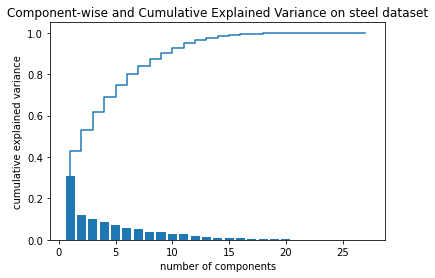

In [13]:
pca = PCA().fit(X_train_scaled)

# https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_,label = 'Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_),label = 'Cumulative explained variance')
plt.title("Component-wise and Cumulative Explained Variance on steel dataset")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Calculating Reconstruction Error


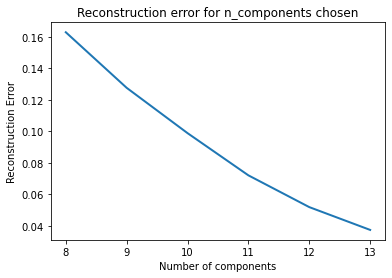

In [14]:
#Reconstruction Error
from sklearn.model_selection import GridSearchCV
print("Calculating Reconstruction Error")
n_components =[8, 9, 10, 11, 12, 13]
reconstruction_error = []
for comp in n_components:

 pca = PCA(n_components = comp)
 X_transformed = pca.fit_transform(X_train_scaled)
 X_projected = pca.inverse_transform(X_transformed)
 reconstruction_error.append(((X_train_scaled - X_projected) ** 2).mean())

 #if(comp == gridSearch.best_estimator_.named_steps['pca'].n_components):
  #chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
#ax2.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen')
plt.show()

In [20]:
# # Choose the number of components that capture 85% of the variance
# num_components = 10

# # Transform the data
# pca = PCA(n_components=num_components)
# pca.fit(X_train_scaled)
# X_train_pca = pca.transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)
n=10
start = time.time()
pca = PCA(n_components= n).fit(X_train_scaled)
print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_pca = pca.transform(X_train_scaled)
print("transformed shape:", X_pca.shape)
print()

Time(s) 0.011371374130249023
original shape: (1495, 27)
transformed shape: (1495, 10)



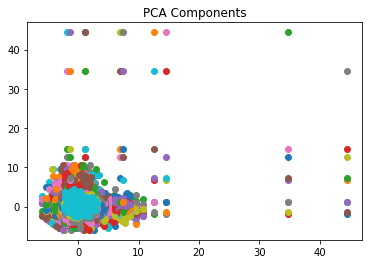

In [16]:
plt.figure(figsize=(6,4))
plt.title('PCA Components')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_pca[:,i], X_pca[:,j])

In [17]:
 #RECONSTRUCTION ERROR
pca = PCA(n_components = 10)
X_test_transformed = pca.fit_transform(X_test_scaled)
X_test_projected = pca.inverse_transform(X_test_transformed)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

0.07625402415912293


### ICA

D:\Anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


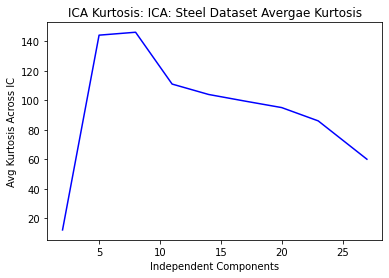

In [18]:
def run_ICA(X,title):
    
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = FastICA(random_state=4)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

run_ICA(X_train_scaled,"ICA: Steel Dataset Avergae Kurtosis")

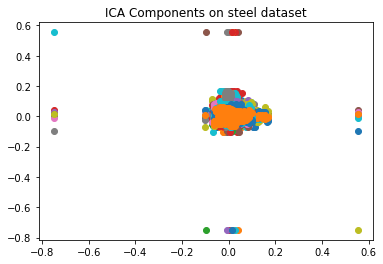

In [19]:
n = 9
ica = FastICA(n_components=n, max_iter=10000, tol=0.1) 
X_ica=ica.fit_transform(X_train_scaled)

plt.figure(figsize=(6,4))
plt.title('ICA Components on steel dataset')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_ica[:,i], X_ica[:,j])

In [24]:
n=9
start = time.time()
ica = FastICA(n_components=n, max_iter=10000, tol=0.1) 
print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_ica=ica.fit_transform(X_train_scaled)
print("transformed shape:", X_ica.shape)
print()

Time(s) 0.0
original shape: (1495, 27)
transformed shape: (1495, 9)



In [25]:
#RECONSTRUCTION ERROR
ica = FastICA(n_components = 9)
X_test_transformed = ica.fit_transform(X_test_scaled)
X_test_projected = ica.inverse_transform(X_test_transformed)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

0.0997553401909808


### RP

Calculating Reconstruction Error


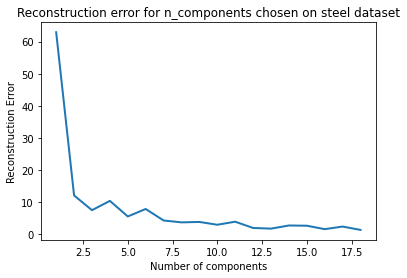

In [22]:
#Reconstruction Error

print("Calculating Reconstruction Error")

n_components =[1,2,3,4,5,6,7,8, 9, 10, 11, 12, 13,14,15,16,17,18]

def inverse_transform_rp(rp, X_transformed, X_train):

    return X_transformed.dot(rp.components_) + np.mean(X_train, axis = 0)


reconstruction_error = []
for comp in n_components:

    rp = random_projection.GaussianRandomProjection(n_components = comp)
    X_transformed = rp.fit_transform(X_train_scaled)
    X_projected = inverse_transform_rp(rp, X_transformed, X_train_scaled)
    reconstruction_error.append(((X_train_scaled - X_projected) ** 2).mean())

 #if(comp == gridSearch.best_estimator_.named_steps['rp'].n_components):
  #chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
#ax2.axvline(gridSearch.best_estimator_.named_steps['rp'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen on steel dataset')
plt.show()

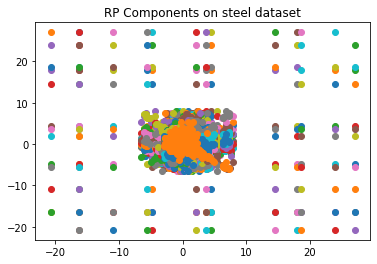

In [31]:
n = 14
rp = random_projection.GaussianRandomProjection(n_components = n)
X_rp=rp.fit_transform(X_train_scaled)

plt.figure(figsize=(6,4))
plt.title('RP Components on steel dataset')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_rp[:,i], X_rp[:,j])

In [32]:
n=14
start = time.time()
rp = random_projection.GaussianRandomProjection(n_components = n)
print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_rp=rp.fit_transform(X_train_scaled)
print("transformed shape:", X_rp.shape)
print()

Time(s) 0.0
original shape: (1495, 27)
transformed shape: (1495, 14)



In [33]:
#RECONSTRUCTION ERROR
rp = random_projection.GaussianRandomProjection(n_components = 14)
X_test_transformed = rp.fit_transform(X_test_scaled)
X_test_projected = inverse_transform_rp(rp, X_test_transformed, X_test_scaled)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

1.753055243755743


### SVD

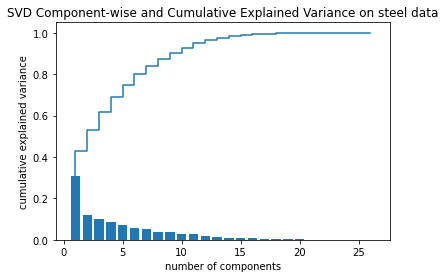

In [26]:
tsvd = TruncatedSVD(n_components=X.shape[1]-1)
X_tsvd = tsvd.fit(X_train_scaled)
# https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
plt.bar(range(1, len(X_tsvd.explained_variance_ratio_) + 1), X_tsvd.explained_variance_ratio_,label = 'Individual explained variance')
plt.step(range(1, len(X_tsvd.explained_variance_ratio_) + 1), np.cumsum(X_tsvd.explained_variance_ratio_),label = 'Cumulative explained variance')
plt.title("SVD Component-wise and Cumulative Explained Variance on steel data")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Calculating Reconstruction Error


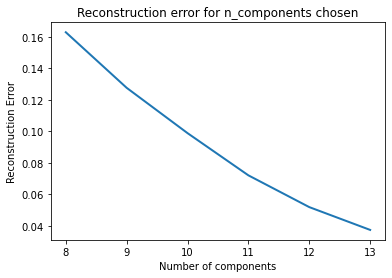

In [27]:
#Reconstruction Error
from sklearn.model_selection import GridSearchCV
print("Calculating Reconstruction Error")
n_components =[8, 9, 10, 11, 12, 13]
reconstruction_error = []

for comp in n_components:
    tsvd = TruncatedSVD(n_components = comp)
    X_transformed = tsvd.fit_transform(X_train_scaled)
    X_projected = tsvd.inverse_transform(X_transformed)
    reconstruction_error.append(((X_train_scaled - X_projected) ** 2).mean())

#if(comp == gridSearch.best_estimator_.named_steps['pca'].n_components):
#chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
#ax2.axvline(gridSearch.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen')
plt.show()

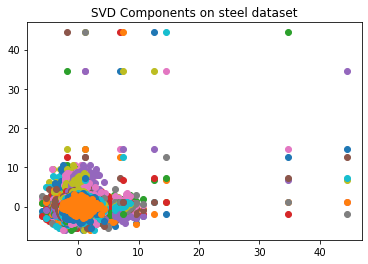

In [29]:
n = 9
tsvd = TruncatedSVD(n_components = n)
X_tsvd=tsvd.fit_transform(X_train_scaled)

plt.figure(figsize=(6,4))
plt.title('SVD Components on steel dataset')

for i in range(0, n):
    for j in range(0, n):
        if i == j:
            continue
        plt.scatter(X_tsvd[:,i], X_tsvd[:,j])

In [30]:
start = time.time()
n = 9
tsvd = TruncatedSVD(n_components = n)
print("Time(s) " + str(time.time() - start))
print("original shape:", X_train_scaled.shape)
X_tsvd=tsvd.fit_transform(X_train_scaled)
print("transformed shape:", X_rp.shape)
print()

Time(s) 0.0
original shape: (1495, 27)
transformed shape: (1495, 7)



In [40]:
 #RECONSTRUCTION ERROR
tsvd = TruncatedSVD(n_components = 9)
X_test_transformed = tsvd.fit_transform(X_test_scaled)
X_test_projected = tsvd.inverse_transform(X_test_transformed)
test_reconstruction_error=((X_test_scaled - X_test_projected) ** 2).mean()
print(test_reconstruction_error)

0.09998051304589455


## DR+Clustering

### PCA + KMeans

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


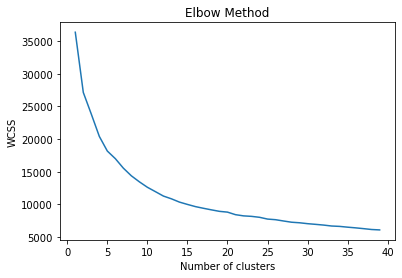

In [41]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

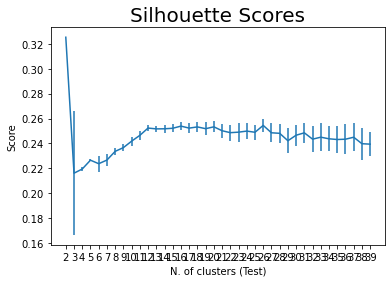

In [47]:
generate_silhoutte_score_plot(X_pca, 40, KMeans)

For n_clusters = 2 The average silhouette_score is : 0.6837902014569623
For n_clusters = 3 The average silhouette_score is : 0.5707657333313285
For n_clusters = 4 The average silhouette_score is : 0.5458011113849509
For n_clusters = 5 The average silhouette_score is : 0.4921427490257105
For n_clusters = 6 The average silhouette_score is : 0.49448876544007964
For n_clusters = 7 The average silhouette_score is : 0.5357362099081291
For n_clusters = 8 The average silhouette_score is : 0.509335095282763


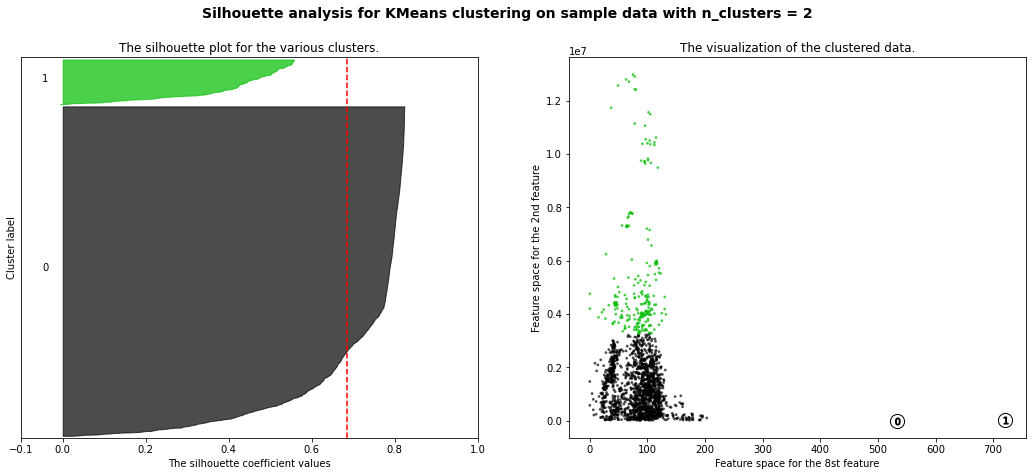

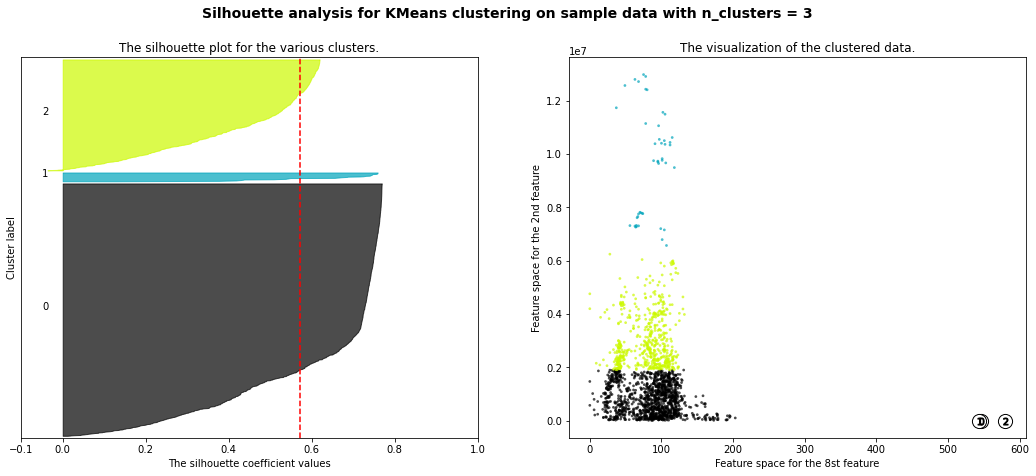

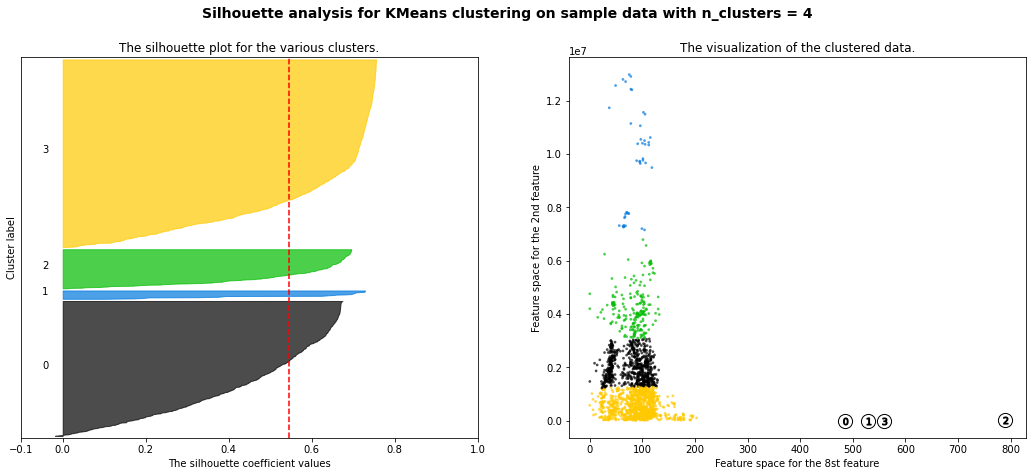

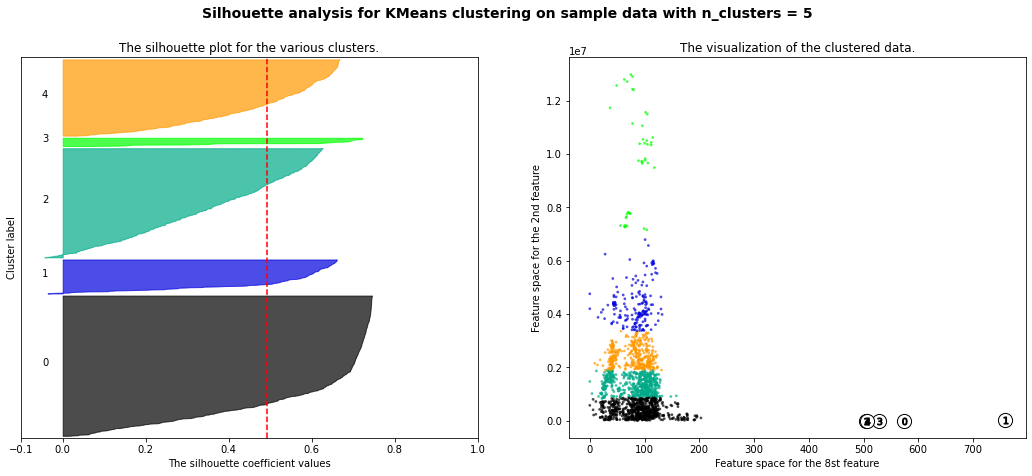

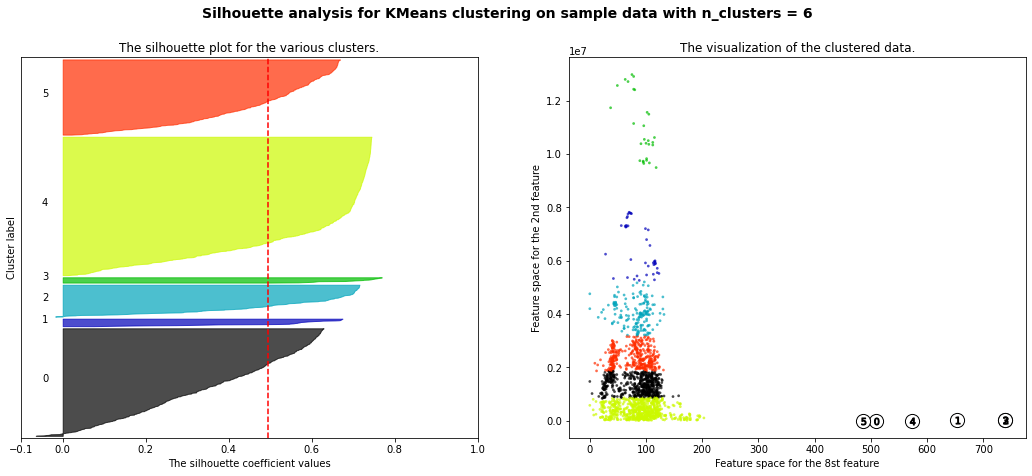

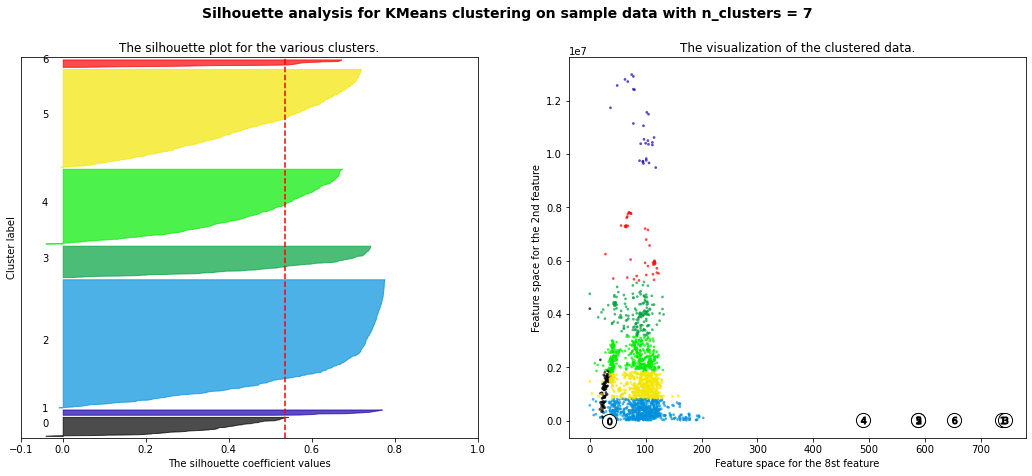

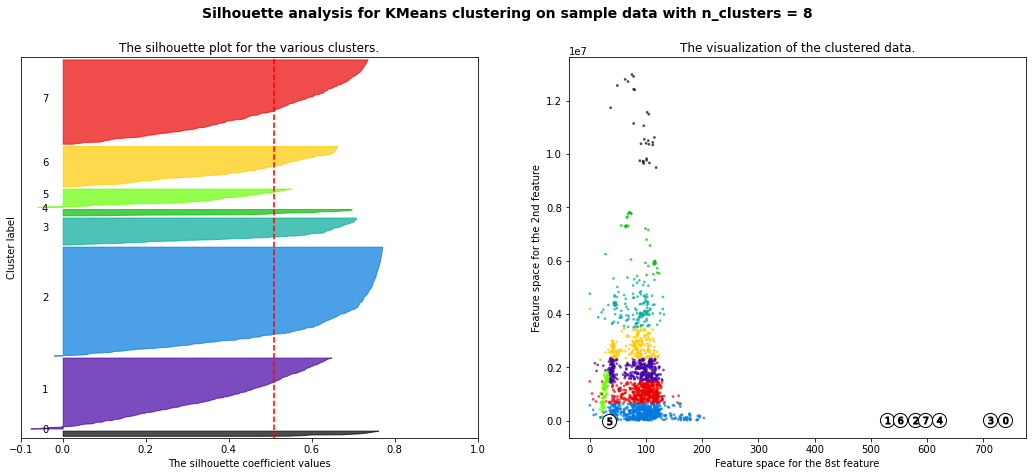

In [54]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2,3,4,5,6,7,8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 8], X.iloc[:, 2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 8st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [35]:
kmeans = KMeans(n_clusters=12, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_pca)

KMeans(n_clusters=12, random_state=0)

In [39]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, kmeans.predict(X_pca))

0.7658397245615685

### ICA + KMeans

In [40]:
kmeans = KMeans(n_clusters=12, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_ica)
rand_score(y_train, kmeans.predict(X_ica))

0.7657895797235765

In [41]:
kmeans = KMeans(n_clusters=12, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_rp)
rand_score(y_train, kmeans.predict(X_rp))

0.7558313521645109

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


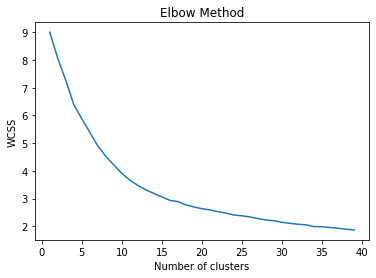

In [49]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_ica)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

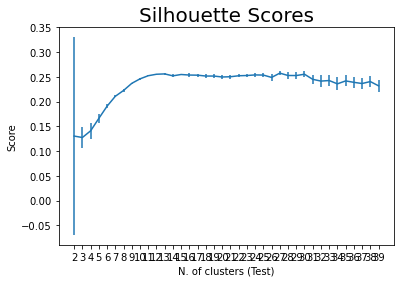

In [55]:
generate_silhoutte_score_plot(X_ica, 40, KMeans)

### RP + KMeans

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


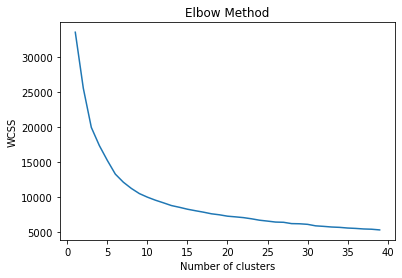

In [50]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_rp)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [42]:
kmeans = KMeans(n_clusters=15, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_rp)
rand_score(y_train, kmeans.predict(X_rp))

0.7615308502684092

### SVD + KMeans

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


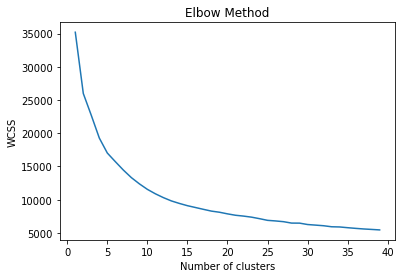

In [52]:
wcss = []
for i in range(1, 40):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_tsvd)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 40), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [43]:
kmeans = KMeans(n_clusters=15, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_tsvd)
rand_score(y_train, kmeans.predict(X_tsvd))

0.775052047655505

### PCA + GMM

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

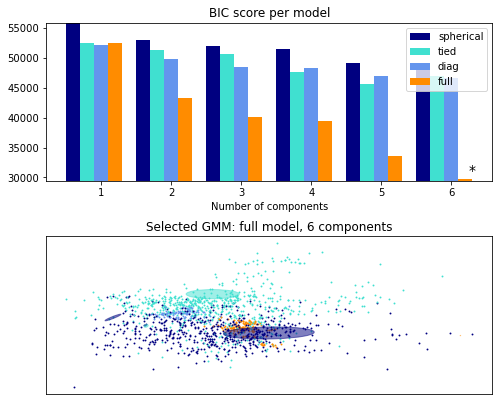

In [44]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_pca)
        bic.append(gmm.bic(X_pca))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_pca)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_pca[Y_ == i, 8], X_pca[Y_ == i, 2], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [45]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, best_gmm.predict(X_pca))

0.7007705291623574

### ICA + GMM

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

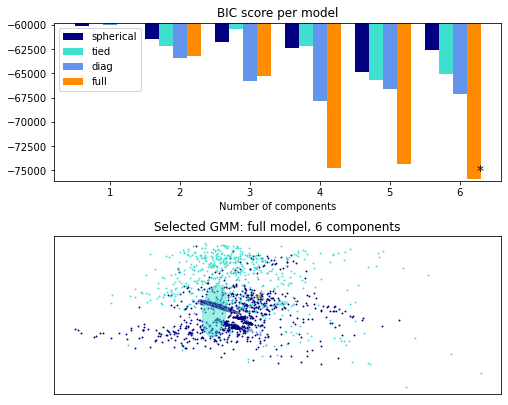

In [46]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_ica)
        bic.append(gmm.bic(X_ica))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_ica)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_ica[Y_ == i, 2], X_ica[Y_ == i, 0], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [47]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, best_gmm.predict(X_ica))

0.6730619243977023

### RP + GMM

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

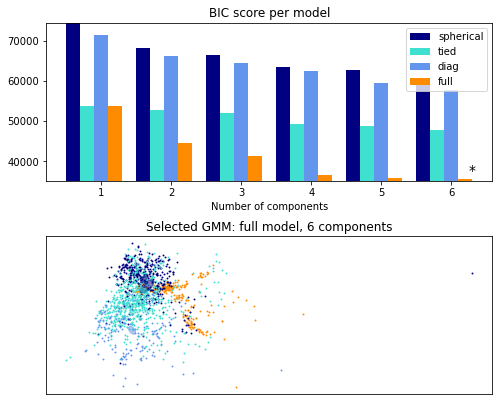

In [48]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_rp)
        bic.append(gmm.bic(X_rp))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_rp)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_rp[Y_ == i, 0], X_rp[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [49]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, best_gmm.predict(X_rp))

0.737130013924147

### SVD + GMM

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

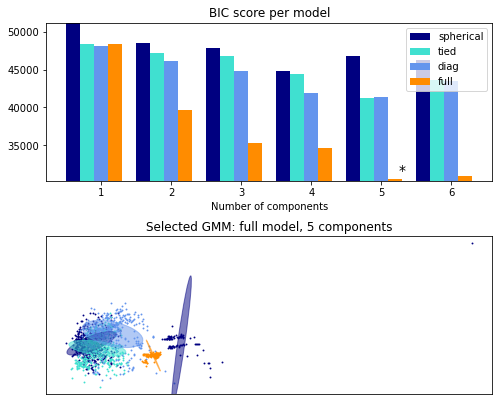

In [50]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(X_tsvd)
        bic.append(gmm.bic(X_tsvd))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(["navy", "turquoise", "cornflowerblue", "darkorange"])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range) : (i + 1) * len(n_components_range)],
            width=0.2,
            color=color,
        )
    )
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title("BIC score per model")
xpos = (
    np.mod(bic.argmin(), len(n_components_range))
    + 0.65
    + 0.2 * np.floor(bic.argmin() / len(n_components_range))
)
plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), "*", fontsize=14)
spl.set_xlabel("Number of components")
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_tsvd)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_, color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_tsvd[Y_ == i, 0], X_tsvd[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[8], v[2], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title(
    f"Selected GMM: {best_gmm.covariance_type} model, "
    f"{best_gmm.n_components} components"
)
plt.subplots_adjust(hspace=0.35, bottom=0.02)
plt.show()

In [51]:
from sklearn.metrics.cluster import rand_score
rand_score(y_train, best_gmm.predict(X_tsvd))

0.6904254699959257

## NN on original data

In [21]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [22]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 27, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history = classifier.fit(X_train_scaled, y_train_encoded, validation_data=(X_test_scaled, y_test_encoded),batch_size = 100, epochs = 1150)

Epoch 1/1150
15/15 [==============================] - 0s 9ms/step - loss: 1.9400 - accuracy: 0.4749 - val_loss: 1.9326 - val_accuracy: 0.4893
Epoch 2/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.9224 - accuracy: 0.5184 - val_loss: 1.9088 - val_accuracy: 0.4947
Epoch 3/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.8865 - accuracy: 0.5151 - val_loss: 1.8593 - val_accuracy: 0.4840
Epoch 4/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.8139 - accuracy: 0.5043 - val_loss: 1.7642 - val_accuracy: 0.4706
Epoch 5/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.6895 - accuracy: 0.4990 - val_loss: 1.6250 - val_accuracy: 0.4626
Epoch 6/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.5336 - accuracy: 0.4896 - val_loss: 1.4917 - val_accuracy: 0.4572
Epoch 7/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.4069 - accuracy: 0.4856 - val_loss: 1.4153 - val_accuracy: 0.4572
Epoch 

15/15 [==============================] - 0s 1ms/step - loss: 0.5901 - accuracy: 0.7592 - val_loss: 0.7382 - val_accuracy: 0.7326
Epoch 116/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5879 - accuracy: 0.7585 - val_loss: 0.7370 - val_accuracy: 0.7299
Epoch 117/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5856 - accuracy: 0.7592 - val_loss: 0.7368 - val_accuracy: 0.7380
Epoch 118/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5850 - accuracy: 0.7585 - val_loss: 0.7373 - val_accuracy: 0.7299
Epoch 119/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5830 - accuracy: 0.7599 - val_loss: 0.7375 - val_accuracy: 0.7299
Epoch 120/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5814 - accuracy: 0.7605 - val_loss: 0.7346 - val_accuracy: 0.7246
Epoch 121/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5798 - accuracy: 0.7592 - val_loss: 0.7352 - val_accuracy: 0.7433
Epoch 1

Epoch 172/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5112 - accuracy: 0.7826 - val_loss: 0.7344 - val_accuracy: 0.7674
Epoch 173/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5092 - accuracy: 0.7819 - val_loss: 0.7342 - val_accuracy: 0.7567
Epoch 174/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5095 - accuracy: 0.7813 - val_loss: 0.7370 - val_accuracy: 0.7594
Epoch 175/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5082 - accuracy: 0.7833 - val_loss: 0.7353 - val_accuracy: 0.7620
Epoch 176/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5074 - accuracy: 0.7819 - val_loss: 0.7350 - val_accuracy: 0.7647
Epoch 177/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5061 - accuracy: 0.7833 - val_loss: 0.7357 - val_accuracy: 0.7540
Epoch 178/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5047 - accuracy: 0.7873 - val_loss: 0.7375 - val_accuracy:

Epoch 229/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4606 - accuracy: 0.8087 - val_loss: 0.7486 - val_accuracy: 0.7781
Epoch 230/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4604 - accuracy: 0.8060 - val_loss: 0.7506 - val_accuracy: 0.7781
Epoch 231/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.8074 - val_loss: 0.7489 - val_accuracy: 0.7727
Epoch 232/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4590 - accuracy: 0.8047 - val_loss: 0.7491 - val_accuracy: 0.7807
Epoch 233/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4583 - accuracy: 0.8067 - val_loss: 0.7514 - val_accuracy: 0.7754
Epoch 234/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4585 - accuracy: 0.8047 - val_loss: 0.7503 - val_accuracy: 0.7807
Epoch 235/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4582 - accuracy: 0.8094 - val_loss: 0.7508 - val_accuracy:

Epoch 286/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4261 - accuracy: 0.8167 - val_loss: 0.7750 - val_accuracy: 0.7888
Epoch 287/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4254 - accuracy: 0.8127 - val_loss: 0.7755 - val_accuracy: 0.7888
Epoch 288/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4252 - accuracy: 0.8154 - val_loss: 0.7764 - val_accuracy: 0.7888
Epoch 289/1150
15/15 [==============================] - 0s 3ms/step - loss: 0.4242 - accuracy: 0.8207 - val_loss: 0.7777 - val_accuracy: 0.7861
Epoch 290/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.8154 - val_loss: 0.7772 - val_accuracy: 0.7914
Epoch 291/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4234 - accuracy: 0.8161 - val_loss: 0.7786 - val_accuracy: 0.7888
Epoch 292/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.8161 - val_loss: 0.7778 - val_accuracy:

Epoch 343/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3997 - accuracy: 0.8241 - val_loss: 0.8094 - val_accuracy: 0.7861
Epoch 344/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3988 - accuracy: 0.8247 - val_loss: 0.8111 - val_accuracy: 0.7834
Epoch 345/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3986 - accuracy: 0.8227 - val_loss: 0.8106 - val_accuracy: 0.7861
Epoch 346/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3980 - accuracy: 0.8261 - val_loss: 0.8129 - val_accuracy: 0.7888
Epoch 347/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.8268 - val_loss: 0.8137 - val_accuracy: 0.7888
Epoch 348/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3976 - accuracy: 0.8234 - val_loss: 0.8145 - val_accuracy: 0.7861
Epoch 349/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3968 - accuracy: 0.8281 - val_loss: 0.8166 - val_accuracy:

Epoch 400/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.8375 - val_loss: 0.8496 - val_accuracy: 0.7727
Epoch 401/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3765 - accuracy: 0.8355 - val_loss: 0.8539 - val_accuracy: 0.7727
Epoch 402/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3779 - accuracy: 0.8341 - val_loss: 0.8558 - val_accuracy: 0.7754
Epoch 403/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3774 - accuracy: 0.8375 - val_loss: 0.8539 - val_accuracy: 0.7701
Epoch 404/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3786 - accuracy: 0.8328 - val_loss: 0.8547 - val_accuracy: 0.7754
Epoch 405/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3783 - accuracy: 0.8388 - val_loss: 0.8555 - val_accuracy: 0.7807
Epoch 406/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3760 - accuracy: 0.8348 - val_loss: 0.8569 - val_accuracy:

Epoch 457/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3601 - accuracy: 0.8401 - val_loss: 0.8921 - val_accuracy: 0.7727
Epoch 458/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3577 - accuracy: 0.8428 - val_loss: 0.8957 - val_accuracy: 0.7754
Epoch 459/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3587 - accuracy: 0.8428 - val_loss: 0.8967 - val_accuracy: 0.7754
Epoch 460/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3580 - accuracy: 0.8415 - val_loss: 0.8968 - val_accuracy: 0.7727
Epoch 461/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3579 - accuracy: 0.8475 - val_loss: 0.8974 - val_accuracy: 0.7754
Epoch 462/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3578 - accuracy: 0.8421 - val_loss: 0.8994 - val_accuracy: 0.7754
Epoch 463/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3569 - accuracy: 0.8441 - val_loss: 0.9008 - val_accuracy:

Epoch 514/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.8542 - val_loss: 0.9400 - val_accuracy: 0.7701
Epoch 515/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3419 - accuracy: 0.8502 - val_loss: 0.9368 - val_accuracy: 0.7647
Epoch 516/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3424 - accuracy: 0.8462 - val_loss: 0.9397 - val_accuracy: 0.7701
Epoch 517/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3424 - accuracy: 0.8508 - val_loss: 0.9415 - val_accuracy: 0.7701
Epoch 518/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3410 - accuracy: 0.8468 - val_loss: 0.9447 - val_accuracy: 0.7701
Epoch 519/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3411 - accuracy: 0.8502 - val_loss: 0.9411 - val_accuracy: 0.7674
Epoch 520/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3402 - accuracy: 0.8508 - val_loss: 0.9410 - val_accuracy:

Epoch 571/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3275 - accuracy: 0.8569 - val_loss: 0.9848 - val_accuracy: 0.7594
Epoch 572/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3270 - accuracy: 0.8542 - val_loss: 0.9856 - val_accuracy: 0.7647
Epoch 573/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3276 - accuracy: 0.8562 - val_loss: 0.9837 - val_accuracy: 0.7620
Epoch 574/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3273 - accuracy: 0.8569 - val_loss: 0.9826 - val_accuracy: 0.7727
Epoch 575/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3269 - accuracy: 0.8575 - val_loss: 0.9856 - val_accuracy: 0.7620
Epoch 576/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3265 - accuracy: 0.8589 - val_loss: 0.9890 - val_accuracy: 0.7620
Epoch 577/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3257 - accuracy: 0.8555 - val_loss: 0.9879 - val_accuracy:

Epoch 628/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3144 - accuracy: 0.8609 - val_loss: 1.0307 - val_accuracy: 0.7540
Epoch 629/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3141 - accuracy: 0.8615 - val_loss: 1.0308 - val_accuracy: 0.7647
Epoch 630/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3136 - accuracy: 0.8595 - val_loss: 1.0287 - val_accuracy: 0.7567
Epoch 631/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3139 - accuracy: 0.8589 - val_loss: 1.0305 - val_accuracy: 0.7594
Epoch 632/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3135 - accuracy: 0.8642 - val_loss: 1.0337 - val_accuracy: 0.7620
Epoch 633/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3128 - accuracy: 0.8602 - val_loss: 1.0339 - val_accuracy: 0.7594
Epoch 634/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3130 - accuracy: 0.8642 - val_loss: 1.0349 - val_accuracy:

Epoch 685/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3033 - accuracy: 0.8649 - val_loss: 1.0775 - val_accuracy: 0.7620
Epoch 686/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3028 - accuracy: 0.8689 - val_loss: 1.0737 - val_accuracy: 0.7620
Epoch 687/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3047 - accuracy: 0.8696 - val_loss: 1.0803 - val_accuracy: 0.7594
Epoch 688/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3026 - accuracy: 0.8676 - val_loss: 1.0791 - val_accuracy: 0.7620
Epoch 689/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3025 - accuracy: 0.8682 - val_loss: 1.0837 - val_accuracy: 0.7594
Epoch 690/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3021 - accuracy: 0.8649 - val_loss: 1.0834 - val_accuracy: 0.7620
Epoch 691/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.3015 - accuracy: 0.8676 - val_loss: 1.0785 - val_accuracy:

Epoch 742/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2908 - accuracy: 0.8702 - val_loss: 1.1216 - val_accuracy: 0.7540
Epoch 743/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2908 - accuracy: 0.8729 - val_loss: 1.1229 - val_accuracy: 0.7487
Epoch 744/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2899 - accuracy: 0.8709 - val_loss: 1.1232 - val_accuracy: 0.7620
Epoch 745/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.8736 - val_loss: 1.1238 - val_accuracy: 0.7513
Epoch 746/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.8729 - val_loss: 1.1259 - val_accuracy: 0.7594
Epoch 747/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2887 - accuracy: 0.8716 - val_loss: 1.1213 - val_accuracy: 0.7513
Epoch 748/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2889 - accuracy: 0.8763 - val_loss: 1.1295 - val_accuracy:

Epoch 799/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2795 - accuracy: 0.8769 - val_loss: 1.1629 - val_accuracy: 0.7460
Epoch 800/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2799 - accuracy: 0.8756 - val_loss: 1.1707 - val_accuracy: 0.7567
Epoch 801/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.8783 - val_loss: 1.1655 - val_accuracy: 0.7487
Epoch 802/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2778 - accuracy: 0.8783 - val_loss: 1.1677 - val_accuracy: 0.7540
Epoch 803/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2773 - accuracy: 0.8742 - val_loss: 1.1701 - val_accuracy: 0.7487
Epoch 804/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2787 - accuracy: 0.8789 - val_loss: 1.1694 - val_accuracy: 0.7513
Epoch 805/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2772 - accuracy: 0.8769 - val_loss: 1.1710 - val_accuracy:

Epoch 856/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2685 - accuracy: 0.8836 - val_loss: 1.2206 - val_accuracy: 0.7513
Epoch 857/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2688 - accuracy: 0.8849 - val_loss: 1.2262 - val_accuracy: 0.7513
Epoch 858/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2690 - accuracy: 0.8816 - val_loss: 1.2226 - val_accuracy: 0.7513
Epoch 859/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2689 - accuracy: 0.8829 - val_loss: 1.2205 - val_accuracy: 0.7487
Epoch 860/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2696 - accuracy: 0.8803 - val_loss: 1.2275 - val_accuracy: 0.7540
Epoch 861/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.8829 - val_loss: 1.2213 - val_accuracy: 0.7513
Epoch 862/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2680 - accuracy: 0.8836 - val_loss: 1.2276 - val_accuracy:

Epoch 913/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2585 - accuracy: 0.8863 - val_loss: 1.2764 - val_accuracy: 0.7433
Epoch 914/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2590 - accuracy: 0.8863 - val_loss: 1.2761 - val_accuracy: 0.7487
Epoch 915/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2585 - accuracy: 0.8870 - val_loss: 1.2826 - val_accuracy: 0.7487
Epoch 916/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2593 - accuracy: 0.8863 - val_loss: 1.2791 - val_accuracy: 0.7460
Epoch 917/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2592 - accuracy: 0.8856 - val_loss: 1.2850 - val_accuracy: 0.7540
Epoch 918/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.8870 - val_loss: 1.2788 - val_accuracy: 0.7433
Epoch 919/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2580 - accuracy: 0.8856 - val_loss: 1.2786 - val_accuracy:

Epoch 970/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.8923 - val_loss: 1.3356 - val_accuracy: 0.7380
Epoch 971/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2496 - accuracy: 0.8910 - val_loss: 1.3350 - val_accuracy: 0.7460
Epoch 972/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2488 - accuracy: 0.8890 - val_loss: 1.3414 - val_accuracy: 0.7487
Epoch 973/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.8883 - val_loss: 1.3442 - val_accuracy: 0.7513
Epoch 974/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2492 - accuracy: 0.8930 - val_loss: 1.3376 - val_accuracy: 0.7460
Epoch 975/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2488 - accuracy: 0.8923 - val_loss: 1.3419 - val_accuracy: 0.7487
Epoch 976/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2496 - accuracy: 0.8930 - val_loss: 1.3397 - val_accuracy:

Epoch 1027/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2405 - accuracy: 0.8977 - val_loss: 1.3955 - val_accuracy: 0.7567
Epoch 1028/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2406 - accuracy: 0.8936 - val_loss: 1.4003 - val_accuracy: 0.7513
Epoch 1029/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2411 - accuracy: 0.8950 - val_loss: 1.4016 - val_accuracy: 0.7567
Epoch 1030/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2406 - accuracy: 0.8990 - val_loss: 1.4013 - val_accuracy: 0.7513
Epoch 1031/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.8943 - val_loss: 1.4049 - val_accuracy: 0.7567
Epoch 1032/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2403 - accuracy: 0.8957 - val_loss: 1.4060 - val_accuracy: 0.7567
Epoch 1033/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2416 - accuracy: 0.8963 - val_loss: 1.4073 - val_ac

15/15 [==============================] - 0s 2ms/step - loss: 0.2261 - accuracy: 0.9070 - val_loss: 1.5096 - val_accuracy: 0.7540
Epoch 1140/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9084 - val_loss: 1.5099 - val_accuracy: 0.7594
Epoch 1141/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2260 - accuracy: 0.9097 - val_loss: 1.5117 - val_accuracy: 0.7540
Epoch 1142/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9084 - val_loss: 1.5097 - val_accuracy: 0.7567
Epoch 1143/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9043 - val_loss: 1.5137 - val_accuracy: 0.7540
Epoch 1144/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.2265 - accuracy: 0.9043 - val_loss: 1.5136 - val_accuracy: 0.7594
Epoch 1145/1150
15/15 [==============================] - 0s 3ms/step - loss: 0.2271 - accuracy: 0.9057 - val_loss: 1.5172 - val_accuracy: 0.7540
E

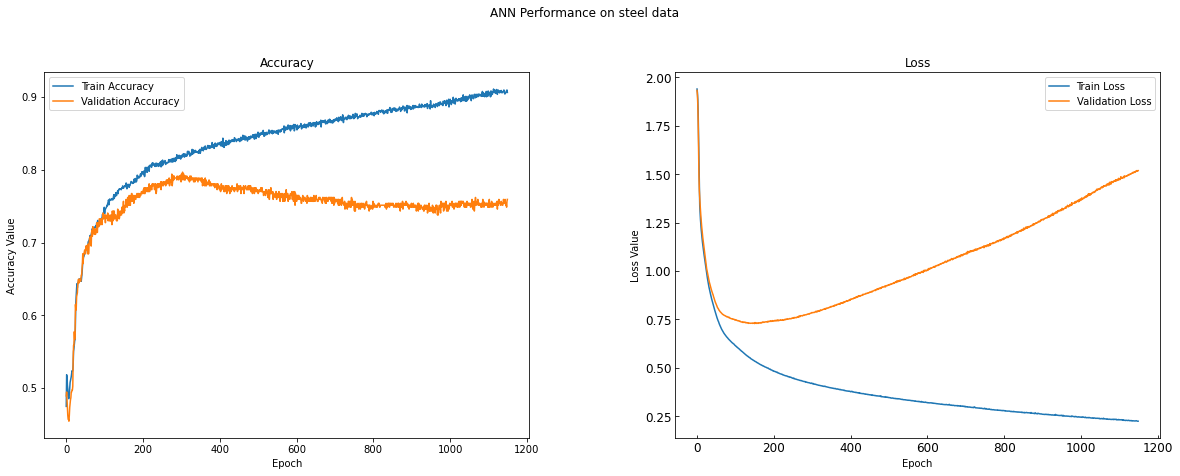

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history.history['loss'], label='Train Loss')
ax2.plot(range(1150), history.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('loss value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss per epoch on original steel dataset')
l2 = ax2.legend(loc="best")

## PCA + NN

In [58]:
X_test_pca = pca.transform(X_test_scaled)

In [102]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history_pca = classifier.fit(X_pca, y_train_encoded, validation_data=(X_test_pca, y_test_encoded),batch_size = 100, epochs = 1150)

Epoch 1/1150
15/15 [==============================] - 0s 11ms/step - loss: 1.9411 - accuracy: 0.2997 - val_loss: 1.9353 - val_accuracy: 0.3984
Epoch 2/1150
15/15 [==============================] - 0s 3ms/step - loss: 1.9292 - accuracy: 0.3512 - val_loss: 1.9227 - val_accuracy: 0.3636
Epoch 3/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9135 - accuracy: 0.3485 - val_loss: 1.9047 - val_accuracy: 0.3636
Epoch 4/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8890 - accuracy: 0.3485 - val_loss: 1.8769 - val_accuracy: 0.3636
Epoch 5/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8502 - accuracy: 0.3485 - val_loss: 1.8354 - val_accuracy: 0.3636
Epoch 6/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.7940 - accuracy: 0.3485 - val_loss: 1.7807 - val_accuracy: 0.3636
Epoch 7/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.7211 - accuracy: 0.3485 - val_loss: 1.7199 - val_accuracy: 0.3636
Epoch

15/15 [==============================] - 0s 2ms/step - loss: 0.8030 - accuracy: 0.6756 - val_loss: 2.1694 - val_accuracy: 0.4519
Epoch 116/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8000 - accuracy: 0.6742 - val_loss: 2.1825 - val_accuracy: 0.4465
Epoch 117/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7975 - accuracy: 0.6776 - val_loss: 2.1961 - val_accuracy: 0.4492
Epoch 118/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7949 - accuracy: 0.6776 - val_loss: 2.1947 - val_accuracy: 0.4465
Epoch 119/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7921 - accuracy: 0.6763 - val_loss: 2.2003 - val_accuracy: 0.4519
Epoch 120/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7898 - accuracy: 0.6789 - val_loss: 2.2141 - val_accuracy: 0.4465
Epoch 121/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7874 - accuracy: 0.6843 - val_loss: 2.2220 - val_accuracy: 0.4465
Epoch 1

Epoch 172/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7024 - accuracy: 0.7365 - val_loss: 2.4483 - val_accuracy: 0.4358
Epoch 173/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7012 - accuracy: 0.7338 - val_loss: 2.4462 - val_accuracy: 0.4412
Epoch 174/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7000 - accuracy: 0.7338 - val_loss: 2.4498 - val_accuracy: 0.4385
Epoch 175/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.7331 - val_loss: 2.4615 - val_accuracy: 0.4358
Epoch 176/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6982 - accuracy: 0.7351 - val_loss: 2.4642 - val_accuracy: 0.4278
Epoch 177/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6968 - accuracy: 0.7284 - val_loss: 2.4629 - val_accuracy: 0.4358
Epoch 178/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6956 - accuracy: 0.7311 - val_loss: 2.4675 - val_accuracy:

Epoch 229/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6504 - accuracy: 0.7398 - val_loss: 2.6380 - val_accuracy: 0.4118
Epoch 230/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6494 - accuracy: 0.7385 - val_loss: 2.6458 - val_accuracy: 0.4198
Epoch 231/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.7411 - val_loss: 2.6411 - val_accuracy: 0.4198
Epoch 232/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6486 - accuracy: 0.7385 - val_loss: 2.6405 - val_accuracy: 0.4198
Epoch 233/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.7425 - val_loss: 2.6455 - val_accuracy: 0.4225
Epoch 234/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6472 - accuracy: 0.7445 - val_loss: 2.6486 - val_accuracy: 0.4225
Epoch 235/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.7418 - val_loss: 2.6485 - val_accuracy:

Epoch 286/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6201 - accuracy: 0.7565 - val_loss: 2.7936 - val_accuracy: 0.4037
Epoch 287/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.7572 - val_loss: 2.7955 - val_accuracy: 0.4064
Epoch 288/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6192 - accuracy: 0.7572 - val_loss: 2.7981 - val_accuracy: 0.4091
Epoch 289/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6183 - accuracy: 0.7572 - val_loss: 2.8065 - val_accuracy: 0.4011
Epoch 290/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6179 - accuracy: 0.7565 - val_loss: 2.8120 - val_accuracy: 0.4037
Epoch 291/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6175 - accuracy: 0.7552 - val_loss: 2.8133 - val_accuracy: 0.4091
Epoch 292/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6180 - accuracy: 0.7599 - val_loss: 2.8189 - val_accuracy:

Epoch 343/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6010 - accuracy: 0.7599 - val_loss: 2.9718 - val_accuracy: 0.4037
Epoch 344/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6014 - accuracy: 0.7559 - val_loss: 2.9766 - val_accuracy: 0.4011
Epoch 345/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6010 - accuracy: 0.7579 - val_loss: 2.9848 - val_accuracy: 0.4037
Epoch 346/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6004 - accuracy: 0.7592 - val_loss: 2.9788 - val_accuracy: 0.4064
Epoch 347/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6000 - accuracy: 0.7579 - val_loss: 2.9853 - val_accuracy: 0.4064
Epoch 348/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.7619 - val_loss: 2.9865 - val_accuracy: 0.4037
Epoch 349/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5997 - accuracy: 0.7592 - val_loss: 2.9852 - val_accuracy:

Epoch 456/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5808 - accuracy: 0.7532 - val_loss: 3.1468 - val_accuracy: 0.3984
Epoch 457/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy: 0.7552 - val_loss: 3.1510 - val_accuracy: 0.4064
Epoch 458/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy: 0.7605 - val_loss: 3.1469 - val_accuracy: 0.4091
Epoch 459/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5806 - accuracy: 0.7585 - val_loss: 3.1493 - val_accuracy: 0.3984
Epoch 460/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.7552 - val_loss: 3.1450 - val_accuracy: 0.4118
Epoch 461/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5802 - accuracy: 0.7599 - val_loss: 3.1531 - val_accuracy: 0.3984
Epoch 462/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5800 - accuracy: 0.7545 - val_loss: 3.1506 - val_accuracy:

Epoch 513/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5739 - accuracy: 0.7572 - val_loss: 3.2288 - val_accuracy: 0.4037
Epoch 514/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5718 - accuracy: 0.7585 - val_loss: 3.2287 - val_accuracy: 0.3957
Epoch 515/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5716 - accuracy: 0.7592 - val_loss: 3.2333 - val_accuracy: 0.3984
Epoch 516/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5715 - accuracy: 0.7565 - val_loss: 3.2244 - val_accuracy: 0.3850
Epoch 517/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5715 - accuracy: 0.7605 - val_loss: 3.2334 - val_accuracy: 0.3904
Epoch 518/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5715 - accuracy: 0.7585 - val_loss: 3.2339 - val_accuracy: 0.3877
Epoch 519/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5710 - accuracy: 0.7545 - val_loss: 3.2350 - val_accuracy:

Epoch 570/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5670 - accuracy: 0.7592 - val_loss: 3.3110 - val_accuracy: 0.3797
Epoch 571/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5662 - accuracy: 0.7599 - val_loss: 3.3117 - val_accuracy: 0.3877
Epoch 572/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5661 - accuracy: 0.7639 - val_loss: 3.3199 - val_accuracy: 0.3850
Epoch 573/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5668 - accuracy: 0.7612 - val_loss: 3.3143 - val_accuracy: 0.3877
Epoch 574/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5667 - accuracy: 0.7605 - val_loss: 3.3094 - val_accuracy: 0.3904
Epoch 575/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5656 - accuracy: 0.7579 - val_loss: 3.3178 - val_accuracy: 0.3850
Epoch 576/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5660 - accuracy: 0.7639 - val_loss: 3.3235 - val_accuracy:

Epoch 627/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5619 - accuracy: 0.7645 - val_loss: 3.3753 - val_accuracy: 0.3850
Epoch 628/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5615 - accuracy: 0.7585 - val_loss: 3.3856 - val_accuracy: 0.3904
Epoch 629/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5619 - accuracy: 0.7605 - val_loss: 3.3850 - val_accuracy: 0.3877
Epoch 630/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5617 - accuracy: 0.7672 - val_loss: 3.3818 - val_accuracy: 0.3824
Epoch 631/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5617 - accuracy: 0.7625 - val_loss: 3.3808 - val_accuracy: 0.3904
Epoch 632/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5608 - accuracy: 0.7612 - val_loss: 3.3923 - val_accuracy: 0.3877
Epoch 633/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5613 - accuracy: 0.7619 - val_loss: 3.3898 - val_accuracy:

Epoch 684/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5579 - accuracy: 0.7659 - val_loss: 3.4370 - val_accuracy: 0.3824
Epoch 685/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5576 - accuracy: 0.7659 - val_loss: 3.4294 - val_accuracy: 0.3850
Epoch 686/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5577 - accuracy: 0.7639 - val_loss: 3.4304 - val_accuracy: 0.3930
Epoch 687/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5581 - accuracy: 0.7632 - val_loss: 3.4446 - val_accuracy: 0.3877
Epoch 688/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5578 - accuracy: 0.7625 - val_loss: 3.4402 - val_accuracy: 0.3930
Epoch 689/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5580 - accuracy: 0.7605 - val_loss: 3.4390 - val_accuracy: 0.3957
Epoch 690/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5582 - accuracy: 0.7639 - val_loss: 3.4401 - val_accuracy:

Epoch 741/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5542 - accuracy: 0.7585 - val_loss: 3.4910 - val_accuracy: 0.3877
Epoch 742/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.7625 - val_loss: 3.4853 - val_accuracy: 0.3770
Epoch 743/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5545 - accuracy: 0.7652 - val_loss: 3.4878 - val_accuracy: 0.3904
Epoch 744/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.7659 - val_loss: 3.4946 - val_accuracy: 0.3824
Epoch 745/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5542 - accuracy: 0.7692 - val_loss: 3.4954 - val_accuracy: 0.3797
Epoch 746/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5540 - accuracy: 0.7625 - val_loss: 3.4981 - val_accuracy: 0.3877
Epoch 747/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5541 - accuracy: 0.7599 - val_loss: 3.4990 - val_accuracy:

Epoch 798/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.7612 - val_loss: 3.5648 - val_accuracy: 0.3770
Epoch 799/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5509 - accuracy: 0.7652 - val_loss: 3.5707 - val_accuracy: 0.3770
Epoch 800/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5512 - accuracy: 0.7639 - val_loss: 3.5653 - val_accuracy: 0.3770
Epoch 801/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5507 - accuracy: 0.7672 - val_loss: 3.5734 - val_accuracy: 0.3717
Epoch 802/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7605 - val_loss: 3.5776 - val_accuracy: 0.3824
Epoch 803/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5518 - accuracy: 0.7632 - val_loss: 3.5821 - val_accuracy: 0.3690
Epoch 804/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5513 - accuracy: 0.7639 - val_loss: 3.5706 - val_accuracy:

Epoch 855/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5473 - accuracy: 0.7625 - val_loss: 3.6552 - val_accuracy: 0.3717
Epoch 856/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5468 - accuracy: 0.7639 - val_loss: 3.6584 - val_accuracy: 0.3717
Epoch 857/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.7632 - val_loss: 3.6606 - val_accuracy: 0.3717
Epoch 858/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.7659 - val_loss: 3.6645 - val_accuracy: 0.3717
Epoch 859/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5467 - accuracy: 0.7612 - val_loss: 3.6656 - val_accuracy: 0.3717
Epoch 860/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5464 - accuracy: 0.7625 - val_loss: 3.6630 - val_accuracy: 0.3717
Epoch 861/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5477 - accuracy: 0.7639 - val_loss: 3.6718 - val_accuracy:

Epoch 912/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5437 - accuracy: 0.7599 - val_loss: 3.7493 - val_accuracy: 0.3663
Epoch 913/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5437 - accuracy: 0.7612 - val_loss: 3.7577 - val_accuracy: 0.3663
Epoch 914/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5433 - accuracy: 0.7605 - val_loss: 3.7515 - val_accuracy: 0.3717
Epoch 915/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5433 - accuracy: 0.7639 - val_loss: 3.7604 - val_accuracy: 0.3717
Epoch 916/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5436 - accuracy: 0.7645 - val_loss: 3.7583 - val_accuracy: 0.3663
Epoch 917/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5431 - accuracy: 0.7605 - val_loss: 3.7632 - val_accuracy: 0.3717
Epoch 918/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5433 - accuracy: 0.7625 - val_loss: 3.7594 - val_accuracy:

Epoch 969/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5396 - accuracy: 0.7612 - val_loss: 3.8382 - val_accuracy: 0.3663
Epoch 970/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5396 - accuracy: 0.7605 - val_loss: 3.8547 - val_accuracy: 0.3663
Epoch 971/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5400 - accuracy: 0.7645 - val_loss: 3.8345 - val_accuracy: 0.3663
Epoch 972/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5395 - accuracy: 0.7605 - val_loss: 3.8485 - val_accuracy: 0.3743
Epoch 973/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5393 - accuracy: 0.7585 - val_loss: 3.8535 - val_accuracy: 0.3690
Epoch 974/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5394 - accuracy: 0.7619 - val_loss: 3.8547 - val_accuracy: 0.3690
Epoch 975/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5387 - accuracy: 0.7645 - val_loss: 3.8555 - val_accuracy:

Epoch 1026/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5366 - accuracy: 0.7632 - val_loss: 3.9557 - val_accuracy: 0.3797
Epoch 1027/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5355 - accuracy: 0.7679 - val_loss: 3.9684 - val_accuracy: 0.3663
Epoch 1028/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5352 - accuracy: 0.7645 - val_loss: 3.9537 - val_accuracy: 0.3690
Epoch 1029/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5355 - accuracy: 0.7639 - val_loss: 3.9631 - val_accuracy: 0.3770
Epoch 1030/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5351 - accuracy: 0.7639 - val_loss: 3.9741 - val_accuracy: 0.3717
Epoch 1031/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5353 - accuracy: 0.7645 - val_loss: 3.9731 - val_accuracy: 0.3743
Epoch 1032/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5354 - accuracy: 0.7666 - val_loss: 3.9708 - val_ac

15/15 [==============================] - 0s 1ms/step - loss: 0.5294 - accuracy: 0.7692 - val_loss: 4.1881 - val_accuracy: 0.3717
Epoch 1139/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7679 - val_loss: 4.1761 - val_accuracy: 0.3717
Epoch 1140/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5292 - accuracy: 0.7652 - val_loss: 4.1767 - val_accuracy: 0.3770
Epoch 1141/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5292 - accuracy: 0.7672 - val_loss: 4.2049 - val_accuracy: 0.3717
Epoch 1142/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5291 - accuracy: 0.7686 - val_loss: 4.1875 - val_accuracy: 0.3690
Epoch 1143/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5291 - accuracy: 0.7659 - val_loss: 4.1889 - val_accuracy: 0.3770
Epoch 1144/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5284 - accuracy: 0.7659 - val_loss: 4.1949 - val_accuracy: 0.3717
E

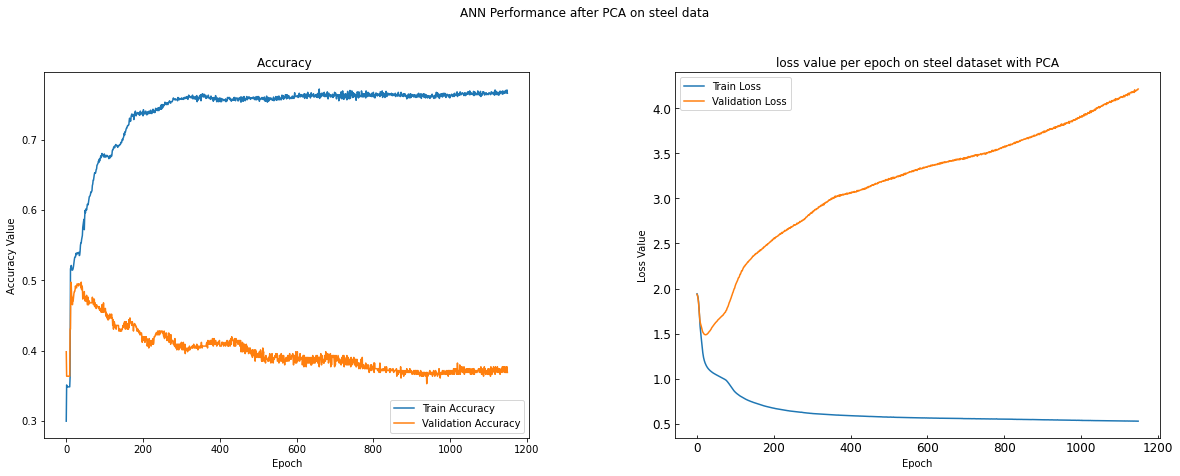

In [103]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance after PCA on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history_pca.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history_pca.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy ')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history_pca.history['loss'], label='Train Loss')
ax2.plot(range(1150), history_pca.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('loss value per epoch on steel dataset with PCA')
l2 = ax2.legend(loc="best")

## ICA + NN

In [78]:
X_test_ica = ica.transform(X_test_scaled)

In [104]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history_ica = classifier.fit(X_ica, y_train_encoded, validation_data=(X_test_ica, y_test_encoded),batch_size = 100, epochs = 1150)

Epoch 1/1150
15/15 [==============================] - 0s 11ms/step - loss: 1.9412 - accuracy: 0.3070 - val_loss: 1.9359 - val_accuracy: 0.3636
Epoch 2/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9311 - accuracy: 0.3485 - val_loss: 1.9257 - val_accuracy: 0.3636
Epoch 3/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9208 - accuracy: 0.3485 - val_loss: 1.9153 - val_accuracy: 0.3636
Epoch 4/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9099 - accuracy: 0.3485 - val_loss: 1.9041 - val_accuracy: 0.3636
Epoch 5/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8981 - accuracy: 0.3485 - val_loss: 1.8919 - val_accuracy: 0.3636
Epoch 6/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8854 - accuracy: 0.3485 - val_loss: 1.8785 - val_accuracy: 0.3636
Epoch 7/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8711 - accuracy: 0.3485 - val_loss: 1.8639 - val_accuracy: 0.3636
Epoch

15/15 [==============================] - 0s 2ms/step - loss: 1.4974 - accuracy: 0.4943 - val_loss: 1.7418 - val_accuracy: 0.2941
Epoch 116/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.4915 - accuracy: 0.4930 - val_loss: 1.7491 - val_accuracy: 0.2941
Epoch 117/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.4856 - accuracy: 0.4916 - val_loss: 1.7566 - val_accuracy: 0.2941
Epoch 118/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.4799 - accuracy: 0.4910 - val_loss: 1.7657 - val_accuracy: 0.2914
Epoch 119/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.4739 - accuracy: 0.4910 - val_loss: 1.7706 - val_accuracy: 0.2914
Epoch 120/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.4679 - accuracy: 0.4916 - val_loss: 1.7816 - val_accuracy: 0.2968
Epoch 121/1150
15/15 [==============================] - ETA: 0s - loss: 1.4226 - accuracy: 0.51 - 0s 2ms/step - loss: 1.4619 - accuracy: 0.4890 - val_l

Epoch 172/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2814 - accuracy: 0.5124 - val_loss: 2.2598 - val_accuracy: 0.3262
Epoch 173/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2798 - accuracy: 0.5124 - val_loss: 2.2721 - val_accuracy: 0.3289
Epoch 174/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2784 - accuracy: 0.5130 - val_loss: 2.2824 - val_accuracy: 0.3316
Epoch 175/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2771 - accuracy: 0.5130 - val_loss: 2.2932 - val_accuracy: 0.3316
Epoch 176/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2756 - accuracy: 0.5130 - val_loss: 2.2889 - val_accuracy: 0.3316
Epoch 177/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2744 - accuracy: 0.5124 - val_loss: 2.3007 - val_accuracy: 0.3316
Epoch 178/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2730 - accuracy: 0.5130 - val_loss: 2.3061 - val_accuracy:

Epoch 229/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2334 - accuracy: 0.5258 - val_loss: 2.5362 - val_accuracy: 0.3636
Epoch 230/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2327 - accuracy: 0.5258 - val_loss: 2.5459 - val_accuracy: 0.3636
Epoch 231/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2322 - accuracy: 0.5258 - val_loss: 2.5600 - val_accuracy: 0.3636
Epoch 232/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2318 - accuracy: 0.5264 - val_loss: 2.5553 - val_accuracy: 0.3663
Epoch 233/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2313 - accuracy: 0.5264 - val_loss: 2.5598 - val_accuracy: 0.3663
Epoch 234/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2308 - accuracy: 0.5264 - val_loss: 2.5597 - val_accuracy: 0.3663
Epoch 235/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2304 - accuracy: 0.5278 - val_loss: 2.5807 - val_accuracy:

Epoch 286/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2080 - accuracy: 0.5344 - val_loss: 2.7066 - val_accuracy: 0.3770
Epoch 287/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2076 - accuracy: 0.5344 - val_loss: 2.7152 - val_accuracy: 0.3770
Epoch 288/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2073 - accuracy: 0.5344 - val_loss: 2.7196 - val_accuracy: 0.3770
Epoch 289/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2067 - accuracy: 0.5344 - val_loss: 2.7186 - val_accuracy: 0.3770
Epoch 290/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2064 - accuracy: 0.5344 - val_loss: 2.7098 - val_accuracy: 0.3770
Epoch 291/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2058 - accuracy: 0.5351 - val_loss: 2.7227 - val_accuracy: 0.3770
Epoch 292/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2055 - accuracy: 0.5344 - val_loss: 2.7248 - val_accuracy:

Epoch 343/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1826 - accuracy: 0.5351 - val_loss: 2.8629 - val_accuracy: 0.3824
Epoch 344/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1821 - accuracy: 0.5365 - val_loss: 2.8849 - val_accuracy: 0.3770
Epoch 345/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1816 - accuracy: 0.5358 - val_loss: 2.8786 - val_accuracy: 0.3824
Epoch 346/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1812 - accuracy: 0.5365 - val_loss: 2.8879 - val_accuracy: 0.3824
Epoch 347/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1807 - accuracy: 0.5365 - val_loss: 2.8888 - val_accuracy: 0.3797
Epoch 348/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1802 - accuracy: 0.5371 - val_loss: 2.8976 - val_accuracy: 0.3797
Epoch 349/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1798 - accuracy: 0.5365 - val_loss: 2.9000 - val_accuracy:

Epoch 400/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1584 - accuracy: 0.5371 - val_loss: 3.0788 - val_accuracy: 0.3824
Epoch 401/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1579 - accuracy: 0.5371 - val_loss: 3.0808 - val_accuracy: 0.3824
Epoch 402/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1576 - accuracy: 0.5365 - val_loss: 3.0792 - val_accuracy: 0.3824
Epoch 403/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1572 - accuracy: 0.5371 - val_loss: 3.0826 - val_accuracy: 0.3824
Epoch 404/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1570 - accuracy: 0.5365 - val_loss: 3.1029 - val_accuracy: 0.3824
Epoch 405/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1564 - accuracy: 0.5378 - val_loss: 3.0892 - val_accuracy: 0.3824
Epoch 406/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1561 - accuracy: 0.5365 - val_loss: 3.0977 - val_accuracy:

Epoch 457/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1382 - accuracy: 0.5799 - val_loss: 3.2944 - val_accuracy: 0.2701
Epoch 458/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1379 - accuracy: 0.5786 - val_loss: 3.2977 - val_accuracy: 0.2701
Epoch 459/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1376 - accuracy: 0.5793 - val_loss: 3.2916 - val_accuracy: 0.2701
Epoch 460/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1374 - accuracy: 0.5819 - val_loss: 3.2994 - val_accuracy: 0.2701
Epoch 461/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1370 - accuracy: 0.5819 - val_loss: 3.3205 - val_accuracy: 0.2701
Epoch 462/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1368 - accuracy: 0.5819 - val_loss: 3.3141 - val_accuracy: 0.2674
Epoch 463/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1365 - accuracy: 0.5799 - val_loss: 3.2963 - val_accuracy:

Epoch 514/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1218 - accuracy: 0.5860 - val_loss: 3.4965 - val_accuracy: 0.2647
Epoch 515/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1215 - accuracy: 0.5880 - val_loss: 3.4999 - val_accuracy: 0.2647
Epoch 516/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1213 - accuracy: 0.5873 - val_loss: 3.5054 - val_accuracy: 0.2647
Epoch 517/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1210 - accuracy: 0.5866 - val_loss: 3.5224 - val_accuracy: 0.2647
Epoch 518/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1207 - accuracy: 0.5880 - val_loss: 3.5154 - val_accuracy: 0.2647
Epoch 519/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1205 - accuracy: 0.5886 - val_loss: 3.5204 - val_accuracy: 0.2647
Epoch 520/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1203 - accuracy: 0.5886 - val_loss: 3.5319 - val_accuracy:

Epoch 571/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1096 - accuracy: 0.5967 - val_loss: 3.6911 - val_accuracy: 0.2727
Epoch 572/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1090 - accuracy: 0.5960 - val_loss: 3.7131 - val_accuracy: 0.2727
Epoch 573/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1087 - accuracy: 0.5960 - val_loss: 3.7107 - val_accuracy: 0.2727
Epoch 574/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1085 - accuracy: 0.5967 - val_loss: 3.7076 - val_accuracy: 0.2727
Epoch 575/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1083 - accuracy: 0.5967 - val_loss: 3.7093 - val_accuracy: 0.2727
Epoch 576/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1088 - accuracy: 0.5953 - val_loss: 3.7432 - val_accuracy: 0.2727
Epoch 577/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1084 - accuracy: 0.5967 - val_loss: 3.7031 - val_accuracy:

Epoch 628/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0981 - accuracy: 0.6000 - val_loss: 3.8377 - val_accuracy: 0.2754
Epoch 629/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0974 - accuracy: 0.6000 - val_loss: 3.8516 - val_accuracy: 0.2781
Epoch 630/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0972 - accuracy: 0.6020 - val_loss: 3.8857 - val_accuracy: 0.2807
Epoch 631/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0971 - accuracy: 0.6007 - val_loss: 3.8765 - val_accuracy: 0.2781
Epoch 632/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0977 - accuracy: 0.6000 - val_loss: 3.8429 - val_accuracy: 0.2781
Epoch 633/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0964 - accuracy: 0.6000 - val_loss: 3.8779 - val_accuracy: 0.2807
Epoch 634/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0966 - accuracy: 0.6007 - val_loss: 3.9062 - val_accuracy:

Epoch 685/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0871 - accuracy: 0.6033 - val_loss: 4.0521 - val_accuracy: 0.2888
Epoch 686/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0869 - accuracy: 0.6020 - val_loss: 4.0378 - val_accuracy: 0.2888
Epoch 687/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0866 - accuracy: 0.6027 - val_loss: 4.0470 - val_accuracy: 0.2888
Epoch 688/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0866 - accuracy: 0.6027 - val_loss: 4.0331 - val_accuracy: 0.2888
Epoch 689/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0862 - accuracy: 0.6013 - val_loss: 4.0457 - val_accuracy: 0.2888
Epoch 690/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0863 - accuracy: 0.6027 - val_loss: 4.0588 - val_accuracy: 0.2888
Epoch 691/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0859 - accuracy: 0.6033 - val_loss: 4.0644 - val_accuracy:

Epoch 798/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0690 - accuracy: 0.6060 - val_loss: 4.3504 - val_accuracy: 0.2968
Epoch 799/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0687 - accuracy: 0.6060 - val_loss: 4.3516 - val_accuracy: 0.2914
Epoch 800/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0686 - accuracy: 0.6040 - val_loss: 4.3518 - val_accuracy: 0.2914
Epoch 801/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0684 - accuracy: 0.6060 - val_loss: 4.3688 - val_accuracy: 0.2995
Epoch 802/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0684 - accuracy: 0.6060 - val_loss: 4.3618 - val_accuracy: 0.2914
Epoch 803/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0680 - accuracy: 0.6040 - val_loss: 4.3557 - val_accuracy: 0.2941
Epoch 804/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0680 - accuracy: 0.6060 - val_loss: 4.3695 - val_accuracy:

Epoch 855/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0599 - accuracy: 0.6067 - val_loss: 4.5410 - val_accuracy: 0.2968
Epoch 856/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0597 - accuracy: 0.6047 - val_loss: 4.5199 - val_accuracy: 0.2968
Epoch 857/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0597 - accuracy: 0.6047 - val_loss: 4.5365 - val_accuracy: 0.2968
Epoch 858/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0593 - accuracy: 0.6060 - val_loss: 4.5471 - val_accuracy: 0.2968
Epoch 859/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0597 - accuracy: 0.6067 - val_loss: 4.5478 - val_accuracy: 0.2968
Epoch 860/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0593 - accuracy: 0.6060 - val_loss: 4.5597 - val_accuracy: 0.2968
Epoch 861/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0589 - accuracy: 0.6067 - val_loss: 4.5483 - val_accuracy:

Epoch 912/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0511 - accuracy: 0.6067 - val_loss: 4.7616 - val_accuracy: 0.3048
Epoch 913/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0511 - accuracy: 0.6060 - val_loss: 4.7613 - val_accuracy: 0.3048
Epoch 914/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0511 - accuracy: 0.6067 - val_loss: 4.7626 - val_accuracy: 0.3075
Epoch 915/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0508 - accuracy: 0.6074 - val_loss: 4.7552 - val_accuracy: 0.3075
Epoch 916/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0508 - accuracy: 0.6067 - val_loss: 4.7775 - val_accuracy: 0.3075
Epoch 917/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0505 - accuracy: 0.6067 - val_loss: 4.7649 - val_accuracy: 0.3075
Epoch 918/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0503 - accuracy: 0.6067 - val_loss: 4.7724 - val_accuracy:

Epoch 969/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0442 - accuracy: 0.6107 - val_loss: 5.0004 - val_accuracy: 0.3075
Epoch 970/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0436 - accuracy: 0.6094 - val_loss: 4.9741 - val_accuracy: 0.3075
Epoch 971/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0438 - accuracy: 0.6087 - val_loss: 4.9796 - val_accuracy: 0.3075
Epoch 972/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0435 - accuracy: 0.6094 - val_loss: 4.9893 - val_accuracy: 0.3075
Epoch 973/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0432 - accuracy: 0.6094 - val_loss: 4.9861 - val_accuracy: 0.3075
Epoch 974/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0434 - accuracy: 0.6094 - val_loss: 5.0175 - val_accuracy: 0.3075
Epoch 975/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0433 - accuracy: 0.6094 - val_loss: 4.9896 - val_accuracy:

Epoch 1026/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0370 - accuracy: 0.6114 - val_loss: 5.2176 - val_accuracy: 0.3102
Epoch 1027/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0370 - accuracy: 0.6107 - val_loss: 5.2253 - val_accuracy: 0.3102
Epoch 1028/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0372 - accuracy: 0.6100 - val_loss: 5.2211 - val_accuracy: 0.3102
Epoch 1029/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0367 - accuracy: 0.6107 - val_loss: 5.2354 - val_accuracy: 0.3102
Epoch 1030/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0367 - accuracy: 0.6107 - val_loss: 5.2386 - val_accuracy: 0.3102
Epoch 1031/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0366 - accuracy: 0.6107 - val_loss: 5.2414 - val_accuracy: 0.3102
Epoch 1032/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0363 - accuracy: 0.6114 - val_loss: 5.2459 - val_ac

15/15 [==============================] - 0s 1ms/step - loss: 1.0241 - accuracy: 0.6127 - val_loss: 5.6813 - val_accuracy: 0.3102
Epoch 1139/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0241 - accuracy: 0.6134 - val_loss: 5.6915 - val_accuracy: 0.3102
Epoch 1140/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0239 - accuracy: 0.6134 - val_loss: 5.7037 - val_accuracy: 0.3102
Epoch 1141/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0239 - accuracy: 0.6120 - val_loss: 5.7132 - val_accuracy: 0.3128
Epoch 1142/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0237 - accuracy: 0.6120 - val_loss: 5.6995 - val_accuracy: 0.3128
Epoch 1143/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.0239 - accuracy: 0.6114 - val_loss: 5.6731 - val_accuracy: 0.3102
Epoch 1144/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0243 - accuracy: 0.6114 - val_loss: 5.7351 - val_accuracy: 0.3128
E

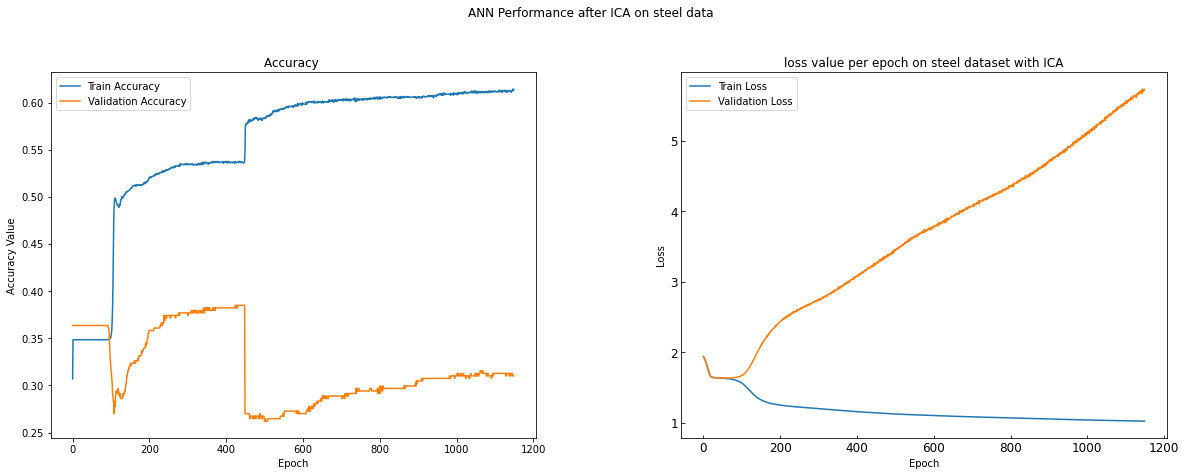

In [105]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance after ICA on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history_ica.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history_ica.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy ')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history_ica.history['loss'], label='Train Loss')
ax2.plot(range(1150), history_ica.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('loss value per epoch on steel dataset with ICA')
l2 = ax2.legend(loc="best")

## RP + NN

In [85]:
X_test_rp = rp.transform(X_test_scaled)

In [87]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history_rp = classifier.fit(X_rp, y_train_encoded, validation_data=(X_test_rp, y_test_encoded),batch_size = 100, epochs = 1150)

Epoch 1/1150
15/15 [==============================] - 0s 10ms/step - loss: 1.9409 - accuracy: 0.3318 - val_loss: 1.9348 - val_accuracy: 0.3636
Epoch 2/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9285 - accuracy: 0.3485 - val_loss: 1.9201 - val_accuracy: 0.3636
Epoch 3/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9107 - accuracy: 0.3485 - val_loss: 1.8980 - val_accuracy: 0.3636
Epoch 4/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8835 - accuracy: 0.3485 - val_loss: 1.8630 - val_accuracy: 0.3636
Epoch 5/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8416 - accuracy: 0.3485 - val_loss: 1.8114 - val_accuracy: 0.3636
Epoch 6/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.7833 - accuracy: 0.3485 - val_loss: 1.7449 - val_accuracy: 0.3636
Epoch 7/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.7146 - accuracy: 0.3485 - val_loss: 1.6734 - val_accuracy: 0.3636
Epoch

15/15 [==============================] - 0s 1ms/step - loss: 0.8626 - accuracy: 0.6535 - val_loss: 0.9792 - val_accuracy: 0.6364
Epoch 116/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8608 - accuracy: 0.6522 - val_loss: 0.9774 - val_accuracy: 0.6337
Epoch 117/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8603 - accuracy: 0.6515 - val_loss: 0.9766 - val_accuracy: 0.6390
Epoch 118/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8589 - accuracy: 0.6522 - val_loss: 0.9777 - val_accuracy: 0.6283
Epoch 119/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8574 - accuracy: 0.6522 - val_loss: 0.9761 - val_accuracy: 0.6364
Epoch 120/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8566 - accuracy: 0.6535 - val_loss: 0.9752 - val_accuracy: 0.6390
Epoch 121/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.8560 - accuracy: 0.6522 - val_loss: 0.9740 - val_accuracy: 0.6417
Epoch 1

Epoch 172/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8204 - accuracy: 0.6635 - val_loss: 0.9510 - val_accuracy: 0.6578
Epoch 173/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8199 - accuracy: 0.6656 - val_loss: 0.9503 - val_accuracy: 0.6578
Epoch 174/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8191 - accuracy: 0.6649 - val_loss: 0.9491 - val_accuracy: 0.6578
Epoch 175/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8188 - accuracy: 0.6642 - val_loss: 0.9489 - val_accuracy: 0.6578
Epoch 176/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8190 - accuracy: 0.6676 - val_loss: 0.9481 - val_accuracy: 0.6604
Epoch 177/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8188 - accuracy: 0.6702 - val_loss: 0.9499 - val_accuracy: 0.6578
Epoch 178/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8178 - accuracy: 0.6702 - val_loss: 0.9475 - val_accuracy:

Epoch 229/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7967 - accuracy: 0.6809 - val_loss: 0.9382 - val_accuracy: 0.6524
Epoch 230/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7964 - accuracy: 0.6749 - val_loss: 0.9369 - val_accuracy: 0.6524
Epoch 231/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7957 - accuracy: 0.6729 - val_loss: 0.9365 - val_accuracy: 0.6551
Epoch 232/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7955 - accuracy: 0.6783 - val_loss: 0.9384 - val_accuracy: 0.6524
Epoch 233/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7953 - accuracy: 0.6756 - val_loss: 0.9373 - val_accuracy: 0.6497
Epoch 234/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7948 - accuracy: 0.6783 - val_loss: 0.9367 - val_accuracy: 0.6497
Epoch 235/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7943 - accuracy: 0.6742 - val_loss: 0.9366 - val_accuracy:

Epoch 342/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7653 - accuracy: 0.7070 - val_loss: 0.9220 - val_accuracy: 0.6497
Epoch 343/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.7650 - accuracy: 0.7064 - val_loss: 0.9207 - val_accuracy: 0.6578
Epoch 344/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7648 - accuracy: 0.7070 - val_loss: 0.9203 - val_accuracy: 0.6551
Epoch 345/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7651 - accuracy: 0.6997 - val_loss: 0.9227 - val_accuracy: 0.6551
Epoch 346/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7637 - accuracy: 0.7043 - val_loss: 0.9200 - val_accuracy: 0.6604
Epoch 347/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7644 - accuracy: 0.7077 - val_loss: 0.9200 - val_accuracy: 0.6578
Epoch 348/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7640 - accuracy: 0.6997 - val_loss: 0.9211 - val_accuracy:

Epoch 399/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7531 - accuracy: 0.7003 - val_loss: 0.9133 - val_accuracy: 0.6631
Epoch 400/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7523 - accuracy: 0.7043 - val_loss: 0.9100 - val_accuracy: 0.6658
Epoch 401/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7522 - accuracy: 0.7064 - val_loss: 0.9120 - val_accuracy: 0.6738
Epoch 402/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7517 - accuracy: 0.7070 - val_loss: 0.9106 - val_accuracy: 0.6658
Epoch 403/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7514 - accuracy: 0.7023 - val_loss: 0.9115 - val_accuracy: 0.6658
Epoch 404/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7511 - accuracy: 0.7084 - val_loss: 0.9102 - val_accuracy: 0.6658
Epoch 405/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7507 - accuracy: 0.7077 - val_loss: 0.9100 - val_accuracy:

Epoch 456/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7416 - accuracy: 0.7124 - val_loss: 0.9025 - val_accuracy: 0.6791
Epoch 457/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7416 - accuracy: 0.7110 - val_loss: 0.9013 - val_accuracy: 0.6765
Epoch 458/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7425 - accuracy: 0.7084 - val_loss: 0.9022 - val_accuracy: 0.6791
Epoch 459/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7412 - accuracy: 0.7130 - val_loss: 0.9027 - val_accuracy: 0.6791
Epoch 460/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7426 - accuracy: 0.7077 - val_loss: 0.9009 - val_accuracy: 0.6765
Epoch 461/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7414 - accuracy: 0.7130 - val_loss: 0.9019 - val_accuracy: 0.6791
Epoch 462/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7416 - accuracy: 0.7151 - val_loss: 0.9022 - val_accuracy:

Epoch 513/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7337 - accuracy: 0.7144 - val_loss: 0.8984 - val_accuracy: 0.6738
Epoch 514/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7333 - accuracy: 0.7151 - val_loss: 0.8953 - val_accuracy: 0.6684
Epoch 515/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7335 - accuracy: 0.7097 - val_loss: 0.8957 - val_accuracy: 0.6684
Epoch 516/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7335 - accuracy: 0.7090 - val_loss: 0.8972 - val_accuracy: 0.6711
Epoch 517/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7331 - accuracy: 0.7164 - val_loss: 0.8961 - val_accuracy: 0.6765
Epoch 518/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7330 - accuracy: 0.7130 - val_loss: 0.8978 - val_accuracy: 0.6658
Epoch 519/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7324 - accuracy: 0.7164 - val_loss: 0.8956 - val_accuracy:

Epoch 570/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7282 - accuracy: 0.7177 - val_loss: 0.8938 - val_accuracy: 0.6898
Epoch 571/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7265 - accuracy: 0.7171 - val_loss: 0.8966 - val_accuracy: 0.6818
Epoch 572/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7279 - accuracy: 0.7151 - val_loss: 0.8941 - val_accuracy: 0.6818
Epoch 573/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7266 - accuracy: 0.7124 - val_loss: 0.8960 - val_accuracy: 0.6791
Epoch 574/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7266 - accuracy: 0.7157 - val_loss: 0.8958 - val_accuracy: 0.6872
Epoch 575/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7269 - accuracy: 0.7124 - val_loss: 0.8959 - val_accuracy: 0.6818
Epoch 576/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7266 - accuracy: 0.7151 - val_loss: 0.8948 - val_accuracy:

Epoch 627/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7219 - accuracy: 0.7124 - val_loss: 0.8948 - val_accuracy: 0.6818
Epoch 628/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7223 - accuracy: 0.7110 - val_loss: 0.8921 - val_accuracy: 0.6925
Epoch 629/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7224 - accuracy: 0.7104 - val_loss: 0.8947 - val_accuracy: 0.6925
Epoch 630/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7216 - accuracy: 0.7110 - val_loss: 0.8947 - val_accuracy: 0.6845
Epoch 631/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7219 - accuracy: 0.7090 - val_loss: 0.8932 - val_accuracy: 0.6898
Epoch 632/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7218 - accuracy: 0.7104 - val_loss: 0.8943 - val_accuracy: 0.6952
Epoch 633/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7217 - accuracy: 0.7130 - val_loss: 0.8934 - val_accuracy:

Epoch 684/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7175 - accuracy: 0.7084 - val_loss: 0.8955 - val_accuracy: 0.6979
Epoch 685/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7180 - accuracy: 0.7130 - val_loss: 0.8950 - val_accuracy: 0.6925
Epoch 686/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7179 - accuracy: 0.7144 - val_loss: 0.8935 - val_accuracy: 0.6979
Epoch 687/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7178 - accuracy: 0.7110 - val_loss: 0.8938 - val_accuracy: 0.7005
Epoch 688/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7178 - accuracy: 0.7130 - val_loss: 0.8942 - val_accuracy: 0.7032
Epoch 689/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7173 - accuracy: 0.7130 - val_loss: 0.8946 - val_accuracy: 0.6925
Epoch 690/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7176 - accuracy: 0.7137 - val_loss: 0.8926 - val_accuracy:

Epoch 741/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7145 - accuracy: 0.7124 - val_loss: 0.8940 - val_accuracy: 0.6952
Epoch 742/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7142 - accuracy: 0.7130 - val_loss: 0.8946 - val_accuracy: 0.6952
Epoch 743/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7139 - accuracy: 0.7144 - val_loss: 0.8939 - val_accuracy: 0.6952
Epoch 744/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7139 - accuracy: 0.7130 - val_loss: 0.8946 - val_accuracy: 0.6952
Epoch 745/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7136 - accuracy: 0.7110 - val_loss: 0.8948 - val_accuracy: 0.6952
Epoch 746/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7132 - accuracy: 0.7144 - val_loss: 0.8935 - val_accuracy: 0.6952
Epoch 747/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7140 - accuracy: 0.7184 - val_loss: 0.8925 - val_accuracy:

Epoch 854/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.7063 - accuracy: 0.7184 - val_loss: 0.8945 - val_accuracy: 0.6979
Epoch 855/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.7071 - accuracy: 0.7151 - val_loss: 0.8935 - val_accuracy: 0.6979
Epoch 856/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7070 - accuracy: 0.7177 - val_loss: 0.8934 - val_accuracy: 0.7005
Epoch 857/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7066 - accuracy: 0.7164 - val_loss: 0.8940 - val_accuracy: 0.7005
Epoch 858/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7063 - accuracy: 0.7184 - val_loss: 0.8930 - val_accuracy: 0.7032
Epoch 859/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7069 - accuracy: 0.7151 - val_loss: 0.8944 - val_accuracy: 0.7032
Epoch 860/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.7164 - val_loss: 0.8928 - val_accuracy:

Epoch 911/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7045 - accuracy: 0.7177 - val_loss: 0.8926 - val_accuracy: 0.7032
Epoch 912/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.7164 - val_loss: 0.8924 - val_accuracy: 0.6979
Epoch 913/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.7191 - val_loss: 0.8931 - val_accuracy: 0.7005
Epoch 914/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7057 - accuracy: 0.7184 - val_loss: 0.8911 - val_accuracy: 0.7059
Epoch 915/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.7211 - val_loss: 0.8941 - val_accuracy: 0.7005
Epoch 916/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.7171 - val_loss: 0.8932 - val_accuracy: 0.6925
Epoch 917/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.7039 - accuracy: 0.7177 - val_loss: 0.8918 - val_accuracy:

Epoch 968/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7034 - accuracy: 0.7231 - val_loss: 0.8903 - val_accuracy: 0.6979
Epoch 969/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.7217 - val_loss: 0.8912 - val_accuracy: 0.7005
Epoch 970/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.7197 - val_loss: 0.8935 - val_accuracy: 0.6979
Epoch 971/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.7191 - val_loss: 0.8928 - val_accuracy: 0.7005
Epoch 972/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7020 - accuracy: 0.7197 - val_loss: 0.8915 - val_accuracy: 0.6979
Epoch 973/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7017 - accuracy: 0.7211 - val_loss: 0.8904 - val_accuracy: 0.6979
Epoch 974/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7018 - accuracy: 0.7204 - val_loss: 0.8909 - val_accuracy:

Epoch 1025/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7000 - accuracy: 0.7204 - val_loss: 0.8944 - val_accuracy: 0.6979
Epoch 1026/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6998 - accuracy: 0.7204 - val_loss: 0.8948 - val_accuracy: 0.6925
Epoch 1027/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6999 - accuracy: 0.7217 - val_loss: 0.8941 - val_accuracy: 0.6925
Epoch 1028/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6994 - accuracy: 0.7191 - val_loss: 0.8944 - val_accuracy: 0.6979
Epoch 1029/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.7184 - val_loss: 0.8942 - val_accuracy: 0.6925
Epoch 1030/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.7191 - val_loss: 0.8946 - val_accuracy: 0.6979
Epoch 1031/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.7211 - val_loss: 0.8924 - val_ac

15/15 [==============================] - 0s 1ms/step - loss: 0.6953 - accuracy: 0.7191 - val_loss: 0.8990 - val_accuracy: 0.6925
Epoch 1138/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.7197 - val_loss: 0.8985 - val_accuracy: 0.6979
Epoch 1139/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.7211 - val_loss: 0.8985 - val_accuracy: 0.7005
Epoch 1140/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.6951 - accuracy: 0.7184 - val_loss: 0.8998 - val_accuracy: 0.6952
Epoch 1141/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.7171 - val_loss: 0.8990 - val_accuracy: 0.6898
Epoch 1142/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.7217 - val_loss: 0.8985 - val_accuracy: 0.6952
Epoch 1143/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.6948 - accuracy: 0.7204 - val_loss: 0.8997 - val_accuracy: 0.6925
E

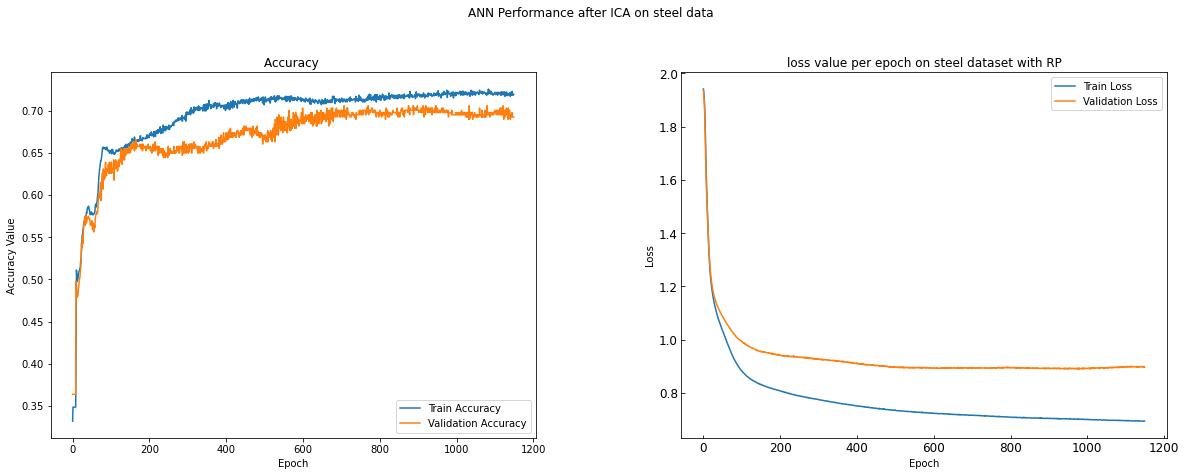

In [88]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance after ICA on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history_rp.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history_rp.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy ')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history_rp.history['loss'], label='Train Loss')
ax2.plot(range(1150), history_rp.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('loss value per epoch on steel dataset with RP')
l2 = ax2.legend(loc="best")

## SVD + NN

In [89]:
X_test_tsvd = tsvd.transform(X_test_scaled)

In [90]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history_SVD = classifier.fit(X_tsvd, y_train_encoded, validation_data=(X_test_tsvd, y_test_encoded),batch_size = 100, epochs = 1150)

Epoch 1/1150
15/15 [==============================] - 0s 11ms/step - loss: 1.9401 - accuracy: 0.3766 - val_loss: 1.9333 - val_accuracy: 0.3636
Epoch 2/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9259 - accuracy: 0.3846 - val_loss: 1.9161 - val_accuracy: 0.3610
Epoch 3/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9049 - accuracy: 0.3913 - val_loss: 1.8889 - val_accuracy: 0.3770
Epoch 4/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8715 - accuracy: 0.4174 - val_loss: 1.8453 - val_accuracy: 0.4225
Epoch 5/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8201 - accuracy: 0.4415 - val_loss: 1.7816 - val_accuracy: 0.4412
Epoch 6/1150
15/15 [==============================] - 0s 3ms/step - loss: 1.7496 - accuracy: 0.4622 - val_loss: 1.7021 - val_accuracy: 0.5027
Epoch 7/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.6686 - accuracy: 0.4963 - val_loss: 1.6212 - val_accuracy: 0.5535
Epoch

15/15 [==============================] - 0s 2ms/step - loss: 0.8779 - accuracy: 0.6756 - val_loss: 0.9363 - val_accuracy: 0.6604
Epoch 116/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8746 - accuracy: 0.6756 - val_loss: 0.9313 - val_accuracy: 0.6631
Epoch 117/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8712 - accuracy: 0.6763 - val_loss: 0.9297 - val_accuracy: 0.6684
Epoch 118/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8677 - accuracy: 0.6783 - val_loss: 0.9261 - val_accuracy: 0.6631
Epoch 119/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8641 - accuracy: 0.6776 - val_loss: 0.9251 - val_accuracy: 0.6738
Epoch 120/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8602 - accuracy: 0.6756 - val_loss: 0.9228 - val_accuracy: 0.6791
Epoch 121/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8569 - accuracy: 0.6776 - val_loss: 0.9191 - val_accuracy: 0.6765
Epoch 1

Epoch 172/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7271 - accuracy: 0.7385 - val_loss: 0.8506 - val_accuracy: 0.7059
Epoch 173/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7259 - accuracy: 0.7385 - val_loss: 0.8488 - val_accuracy: 0.7032
Epoch 174/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7245 - accuracy: 0.7425 - val_loss: 0.8476 - val_accuracy: 0.7086
Epoch 175/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7228 - accuracy: 0.7365 - val_loss: 0.8482 - val_accuracy: 0.7032
Epoch 176/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7208 - accuracy: 0.7378 - val_loss: 0.8460 - val_accuracy: 0.7005
Epoch 177/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7192 - accuracy: 0.7405 - val_loss: 0.8474 - val_accuracy: 0.7005
Epoch 178/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7175 - accuracy: 0.7411 - val_loss: 0.8459 - val_accuracy:

Epoch 229/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.7391 - val_loss: 0.8021 - val_accuracy: 0.6979
Epoch 230/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.7398 - val_loss: 0.8005 - val_accuracy: 0.7005
Epoch 231/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6601 - accuracy: 0.7425 - val_loss: 0.8006 - val_accuracy: 0.6979
Epoch 232/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6600 - accuracy: 0.7418 - val_loss: 0.7995 - val_accuracy: 0.6952
Epoch 233/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6583 - accuracy: 0.7391 - val_loss: 0.7987 - val_accuracy: 0.7005
Epoch 234/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6587 - accuracy: 0.7391 - val_loss: 0.8001 - val_accuracy: 0.6979
Epoch 235/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6574 - accuracy: 0.7418 - val_loss: 0.7980 - val_accuracy:

Epoch 342/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6154 - accuracy: 0.7599 - val_loss: 0.7671 - val_accuracy: 0.7139
Epoch 343/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6147 - accuracy: 0.7612 - val_loss: 0.7659 - val_accuracy: 0.7219
Epoch 344/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.7619 - val_loss: 0.7688 - val_accuracy: 0.7219
Epoch 345/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6143 - accuracy: 0.7619 - val_loss: 0.7669 - val_accuracy: 0.7193
Epoch 346/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6145 - accuracy: 0.7605 - val_loss: 0.7645 - val_accuracy: 0.7166
Epoch 347/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6149 - accuracy: 0.7625 - val_loss: 0.7676 - val_accuracy: 0.7193
Epoch 348/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.6133 - accuracy: 0.7605 - val_loss: 0.7654 - val_accuracy:

Epoch 455/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5962 - accuracy: 0.7625 - val_loss: 0.7711 - val_accuracy: 0.7139
Epoch 456/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5959 - accuracy: 0.7686 - val_loss: 0.7703 - val_accuracy: 0.7166
Epoch 457/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5953 - accuracy: 0.7639 - val_loss: 0.7689 - val_accuracy: 0.7219
Epoch 458/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5960 - accuracy: 0.7639 - val_loss: 0.7702 - val_accuracy: 0.7166
Epoch 459/1150
15/15 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.78 - 0s 2ms/step - loss: 0.5951 - accuracy: 0.7652 - val_loss: 0.7696 - val_accuracy: 0.7193
Epoch 460/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5956 - accuracy: 0.7632 - val_loss: 0.7699 - val_accuracy: 0.7219
Epoch 461/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5953 - accuracy:

Epoch 568/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5830 - accuracy: 0.7619 - val_loss: 0.7857 - val_accuracy: 0.7112
Epoch 569/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5823 - accuracy: 0.7632 - val_loss: 0.7836 - val_accuracy: 0.7139
Epoch 570/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5826 - accuracy: 0.7625 - val_loss: 0.7834 - val_accuracy: 0.7139
Epoch 571/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5822 - accuracy: 0.7639 - val_loss: 0.7839 - val_accuracy: 0.7139
Epoch 572/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5820 - accuracy: 0.7625 - val_loss: 0.7840 - val_accuracy: 0.7139
Epoch 573/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5825 - accuracy: 0.7612 - val_loss: 0.7831 - val_accuracy: 0.7193
Epoch 574/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5818 - accuracy: 0.7645 - val_loss: 0.7854 - val_accuracy:

Epoch 625/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5767 - accuracy: 0.7619 - val_loss: 0.7872 - val_accuracy: 0.7139
Epoch 626/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5770 - accuracy: 0.7612 - val_loss: 0.7868 - val_accuracy: 0.7219
Epoch 627/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5781 - accuracy: 0.7625 - val_loss: 0.7887 - val_accuracy: 0.7112
Epoch 628/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5770 - accuracy: 0.7605 - val_loss: 0.7877 - val_accuracy: 0.7139
Epoch 629/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5765 - accuracy: 0.7612 - val_loss: 0.7892 - val_accuracy: 0.7193
Epoch 630/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5768 - accuracy: 0.7612 - val_loss: 0.7889 - val_accuracy: 0.7193
Epoch 631/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5767 - accuracy: 0.7612 - val_loss: 0.7874 - val_accuracy:

Epoch 682/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5726 - accuracy: 0.7612 - val_loss: 0.7914 - val_accuracy: 0.7246
Epoch 683/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5722 - accuracy: 0.7612 - val_loss: 0.7927 - val_accuracy: 0.7112
Epoch 684/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7599 - val_loss: 0.7924 - val_accuracy: 0.7193
Epoch 685/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5723 - accuracy: 0.7625 - val_loss: 0.7929 - val_accuracy: 0.7193
Epoch 686/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5719 - accuracy: 0.7605 - val_loss: 0.7929 - val_accuracy: 0.7193
Epoch 687/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5718 - accuracy: 0.7619 - val_loss: 0.7925 - val_accuracy: 0.7219
Epoch 688/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5717 - accuracy: 0.7639 - val_loss: 0.7931 - val_accuracy:

Epoch 739/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5684 - accuracy: 0.7639 - val_loss: 0.7940 - val_accuracy: 0.7193
Epoch 740/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5687 - accuracy: 0.7639 - val_loss: 0.7981 - val_accuracy: 0.7059
Epoch 741/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5677 - accuracy: 0.7625 - val_loss: 0.7966 - val_accuracy: 0.7112
Epoch 742/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5679 - accuracy: 0.7619 - val_loss: 0.7942 - val_accuracy: 0.7139
Epoch 743/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 0.7625 - val_loss: 0.7959 - val_accuracy: 0.7086
Epoch 744/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5680 - accuracy: 0.7639 - val_loss: 0.7945 - val_accuracy: 0.7193
Epoch 745/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5677 - accuracy: 0.7619 - val_loss: 0.7950 - val_accuracy:

Epoch 852/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5609 - accuracy: 0.7639 - val_loss: 0.8069 - val_accuracy: 0.7166
Epoch 853/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.7625 - val_loss: 0.8073 - val_accuracy: 0.7112
Epoch 854/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5609 - accuracy: 0.7659 - val_loss: 0.8088 - val_accuracy: 0.7059
Epoch 855/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5608 - accuracy: 0.7652 - val_loss: 0.8070 - val_accuracy: 0.7139
Epoch 856/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5607 - accuracy: 0.7666 - val_loss: 0.8088 - val_accuracy: 0.7032
Epoch 857/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5602 - accuracy: 0.7632 - val_loss: 0.8062 - val_accuracy: 0.7139
Epoch 858/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5599 - accuracy: 0.7652 - val_loss: 0.8083 - val_accuracy:

Epoch 909/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5575 - accuracy: 0.7666 - val_loss: 0.8079 - val_accuracy: 0.7246
Epoch 910/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.7639 - val_loss: 0.8082 - val_accuracy: 0.7193
Epoch 911/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5573 - accuracy: 0.7652 - val_loss: 0.8098 - val_accuracy: 0.7139
Epoch 912/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5567 - accuracy: 0.7666 - val_loss: 0.8091 - val_accuracy: 0.7166
Epoch 913/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5567 - accuracy: 0.7666 - val_loss: 0.8090 - val_accuracy: 0.7193
Epoch 914/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5574 - accuracy: 0.7645 - val_loss: 0.8084 - val_accuracy: 0.7219
Epoch 915/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5571 - accuracy: 0.7686 - val_loss: 0.8102 - val_accuracy:

Epoch 966/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5546 - accuracy: 0.7706 - val_loss: 0.8090 - val_accuracy: 0.7166
Epoch 967/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5535 - accuracy: 0.7686 - val_loss: 0.8102 - val_accuracy: 0.7112
Epoch 968/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5541 - accuracy: 0.7732 - val_loss: 0.8094 - val_accuracy: 0.7139
Epoch 969/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5534 - accuracy: 0.7719 - val_loss: 0.8095 - val_accuracy: 0.7139
Epoch 970/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5537 - accuracy: 0.7692 - val_loss: 0.8102 - val_accuracy: 0.7059
Epoch 971/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5531 - accuracy: 0.7739 - val_loss: 0.8092 - val_accuracy: 0.7112
Epoch 972/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5537 - accuracy: 0.7666 - val_loss: 0.8093 - val_accuracy:

Epoch 1023/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5510 - accuracy: 0.7746 - val_loss: 0.8119 - val_accuracy: 0.7139
Epoch 1024/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5502 - accuracy: 0.7719 - val_loss: 0.8118 - val_accuracy: 0.7139
Epoch 1025/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5514 - accuracy: 0.7746 - val_loss: 0.8119 - val_accuracy: 0.7166
Epoch 1026/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5510 - accuracy: 0.7706 - val_loss: 0.8119 - val_accuracy: 0.7166
Epoch 1027/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5502 - accuracy: 0.7739 - val_loss: 0.8130 - val_accuracy: 0.7139
Epoch 1028/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.7739 - val_loss: 0.8132 - val_accuracy: 0.7112
Epoch 1029/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5500 - accuracy: 0.7719 - val_loss: 0.8126 - val_ac

15/15 [==============================] - 0s 2ms/step - loss: 0.5450 - accuracy: 0.7719 - val_loss: 0.8177 - val_accuracy: 0.7299
Epoch 1136/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5453 - accuracy: 0.7732 - val_loss: 0.8163 - val_accuracy: 0.7299
Epoch 1137/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5443 - accuracy: 0.7753 - val_loss: 0.8171 - val_accuracy: 0.7166
Epoch 1138/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5448 - accuracy: 0.7746 - val_loss: 0.8154 - val_accuracy: 0.7326
Epoch 1139/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5440 - accuracy: 0.7732 - val_loss: 0.8161 - val_accuracy: 0.7299
Epoch 1140/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.5443 - accuracy: 0.7726 - val_loss: 0.8157 - val_accuracy: 0.7299
Epoch 1141/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.5443 - accuracy: 0.7759 - val_loss: 0.8157 - val_accuracy: 0.7299
E

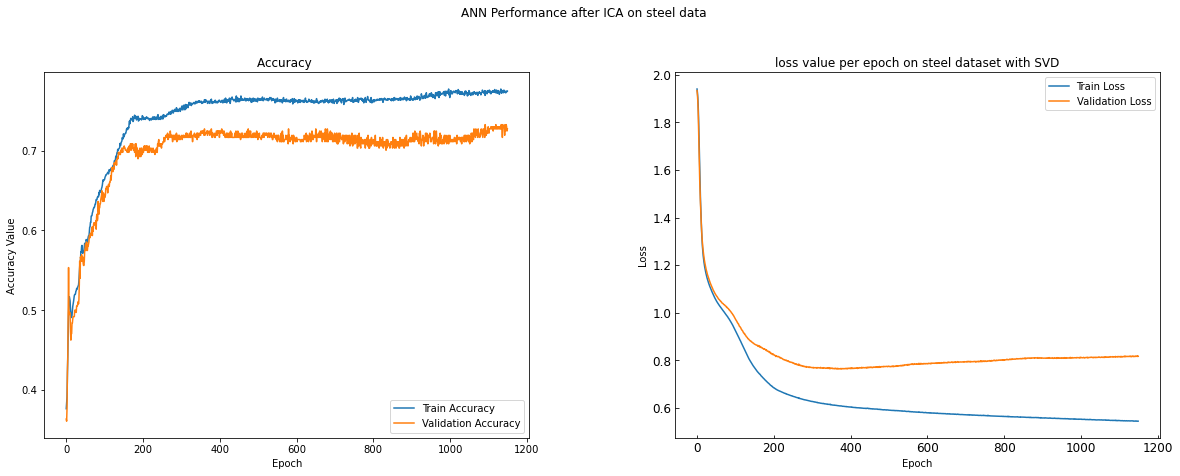

In [92]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance after ICA on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history_SVD.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history_SVD.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy ')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history_SVD.history['loss'], label='Train Loss')
ax2.plot(range(1150), history_SVD.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('loss value per epoch on steel dataset with SVD')
l2 = ax2.legend(loc="best")

## KMeans + NN

In [96]:
k_means =KMeans(n_clusters=7, max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_train_scaled)
X_train_kmeans = kmeans.transform(X_train_scaled)
X_test_kmeans = kmeans.transform(X_test_scaled)

In [97]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history_KMeans = classifier.fit(X_train_kmeans, y_train_encoded, validation_data=(X_test_kmeans, y_test_encoded),batch_size = 100, epochs = 1150)

Epoch 1/1150
15/15 [==============================] - 0s 11ms/step - loss: 1.9297 - accuracy: 0.3485 - val_loss: 1.9045 - val_accuracy: 0.3636
Epoch 2/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8664 - accuracy: 0.3485 - val_loss: 1.7982 - val_accuracy: 0.3636
Epoch 3/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.7316 - accuracy: 0.3485 - val_loss: 1.6645 - val_accuracy: 0.3636
Epoch 4/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.6622 - accuracy: 0.3485 - val_loss: 1.6462 - val_accuracy: 0.3636
Epoch 5/1150
15/15 [==============================] - 0s 3ms/step - loss: 1.6493 - accuracy: 0.3485 - val_loss: 1.6389 - val_accuracy: 0.3636
Epoch 6/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.6433 - accuracy: 0.3485 - val_loss: 1.6356 - val_accuracy: 0.3636
Epoch 7/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.6416 - accuracy: 0.3485 - val_loss: 1.6344 - val_accuracy: 0.3636
Epoch

15/15 [==============================] - 0s 2ms/step - loss: 1.1578 - accuracy: 0.5585 - val_loss: 1.1588 - val_accuracy: 0.5749
Epoch 116/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1571 - accuracy: 0.5666 - val_loss: 1.1599 - val_accuracy: 0.5802
Epoch 117/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1550 - accuracy: 0.5632 - val_loss: 1.1575 - val_accuracy: 0.5695
Epoch 118/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1631 - accuracy: 0.5545 - val_loss: 1.1596 - val_accuracy: 0.5722
Epoch 119/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1542 - accuracy: 0.5599 - val_loss: 1.1586 - val_accuracy: 0.5909
Epoch 120/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1531 - accuracy: 0.5645 - val_loss: 1.1525 - val_accuracy: 0.5775
Epoch 121/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1524 - accuracy: 0.5672 - val_loss: 1.1516 - val_accuracy: 0.5695
Epoch 1

Epoch 172/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0566 - accuracy: 0.6094 - val_loss: 1.0681 - val_accuracy: 0.6016
Epoch 173/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0480 - accuracy: 0.6080 - val_loss: 1.0521 - val_accuracy: 0.5909
Epoch 174/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0348 - accuracy: 0.6167 - val_loss: 1.0467 - val_accuracy: 0.5963
Epoch 175/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0252 - accuracy: 0.6268 - val_loss: 1.0342 - val_accuracy: 0.5963
Epoch 176/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0195 - accuracy: 0.6174 - val_loss: 1.0444 - val_accuracy: 0.6016
Epoch 177/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0123 - accuracy: 0.6261 - val_loss: 1.0240 - val_accuracy: 0.6043
Epoch 178/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.0045 - accuracy: 0.6221 - val_loss: 1.0156 - val_accuracy:

Epoch 229/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9326 - accuracy: 0.6502 - val_loss: 0.9557 - val_accuracy: 0.6497
Epoch 230/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9310 - accuracy: 0.6482 - val_loss: 0.9683 - val_accuracy: 0.6417
Epoch 231/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9292 - accuracy: 0.6435 - val_loss: 0.9520 - val_accuracy: 0.6471
Epoch 232/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9315 - accuracy: 0.6508 - val_loss: 0.9554 - val_accuracy: 0.6390
Epoch 233/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9291 - accuracy: 0.6488 - val_loss: 0.9516 - val_accuracy: 0.6444
Epoch 234/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9284 - accuracy: 0.6455 - val_loss: 0.9500 - val_accuracy: 0.6444
Epoch 235/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9308 - accuracy: 0.6435 - val_loss: 0.9505 - val_accuracy:

Epoch 286/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9077 - accuracy: 0.6508 - val_loss: 0.9360 - val_accuracy: 0.6524
Epoch 287/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9049 - accuracy: 0.6528 - val_loss: 0.9332 - val_accuracy: 0.6417
Epoch 288/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9041 - accuracy: 0.6508 - val_loss: 0.9402 - val_accuracy: 0.6444
Epoch 289/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9039 - accuracy: 0.6515 - val_loss: 0.9327 - val_accuracy: 0.6497
Epoch 290/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9045 - accuracy: 0.6482 - val_loss: 0.9322 - val_accuracy: 0.6471
Epoch 291/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9070 - accuracy: 0.6468 - val_loss: 0.9347 - val_accuracy: 0.6417
Epoch 292/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.9091 - accuracy: 0.6542 - val_loss: 0.9315 - val_accuracy:

Epoch 343/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8879 - accuracy: 0.6515 - val_loss: 0.9246 - val_accuracy: 0.6417
Epoch 344/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8877 - accuracy: 0.6528 - val_loss: 0.9210 - val_accuracy: 0.6497
Epoch 345/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8872 - accuracy: 0.6555 - val_loss: 0.9226 - val_accuracy: 0.6471
Epoch 346/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8844 - accuracy: 0.6569 - val_loss: 0.9164 - val_accuracy: 0.6497
Epoch 347/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8893 - accuracy: 0.6528 - val_loss: 0.9287 - val_accuracy: 0.6390
Epoch 348/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8932 - accuracy: 0.6488 - val_loss: 0.9476 - val_accuracy: 0.6310
Epoch 349/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8921 - accuracy: 0.6542 - val_loss: 0.9165 - val_accuracy:

Epoch 400/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8766 - accuracy: 0.6528 - val_loss: 0.9133 - val_accuracy: 0.6471
Epoch 401/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8792 - accuracy: 0.6535 - val_loss: 0.9162 - val_accuracy: 0.6471
Epoch 402/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8791 - accuracy: 0.6508 - val_loss: 0.9134 - val_accuracy: 0.6390
Epoch 403/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8791 - accuracy: 0.6535 - val_loss: 0.9173 - val_accuracy: 0.6551
Epoch 404/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8749 - accuracy: 0.6502 - val_loss: 0.9115 - val_accuracy: 0.6524
Epoch 405/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8746 - accuracy: 0.6569 - val_loss: 0.9192 - val_accuracy: 0.6444
Epoch 406/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8859 - accuracy: 0.6502 - val_loss: 0.9108 - val_accuracy:

Epoch 457/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8684 - accuracy: 0.6575 - val_loss: 0.9018 - val_accuracy: 0.6578
Epoch 458/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8698 - accuracy: 0.6515 - val_loss: 0.9097 - val_accuracy: 0.6390
Epoch 459/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8684 - accuracy: 0.6569 - val_loss: 0.9186 - val_accuracy: 0.6390
Epoch 460/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8685 - accuracy: 0.6562 - val_loss: 0.9034 - val_accuracy: 0.6524
Epoch 461/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8662 - accuracy: 0.6502 - val_loss: 0.9149 - val_accuracy: 0.6364
Epoch 462/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8694 - accuracy: 0.6582 - val_loss: 0.9051 - val_accuracy: 0.6471
Epoch 463/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8658 - accuracy: 0.6535 - val_loss: 0.9043 - val_accuracy:

Epoch 514/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8582 - accuracy: 0.6656 - val_loss: 0.8946 - val_accuracy: 0.6578
Epoch 515/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8565 - accuracy: 0.6669 - val_loss: 0.8990 - val_accuracy: 0.6497
Epoch 516/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8656 - accuracy: 0.6622 - val_loss: 0.9196 - val_accuracy: 0.6471
Epoch 517/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8663 - accuracy: 0.6575 - val_loss: 0.8941 - val_accuracy: 0.6524
Epoch 518/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8589 - accuracy: 0.6642 - val_loss: 0.8994 - val_accuracy: 0.6497
Epoch 519/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8571 - accuracy: 0.6676 - val_loss: 0.8930 - val_accuracy: 0.6578
Epoch 520/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8565 - accuracy: 0.6649 - val_loss: 0.8971 - val_accuracy:

Epoch 571/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8512 - accuracy: 0.6716 - val_loss: 0.8875 - val_accuracy: 0.6604
Epoch 572/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8511 - accuracy: 0.6662 - val_loss: 0.8976 - val_accuracy: 0.6390
Epoch 573/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8473 - accuracy: 0.6689 - val_loss: 0.8884 - val_accuracy: 0.6684
Epoch 574/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8553 - accuracy: 0.6642 - val_loss: 0.8928 - val_accuracy: 0.6471
Epoch 575/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8483 - accuracy: 0.6676 - val_loss: 0.8916 - val_accuracy: 0.6497
Epoch 576/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8483 - accuracy: 0.6615 - val_loss: 0.8897 - val_accuracy: 0.6658
Epoch 577/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8489 - accuracy: 0.6702 - val_loss: 0.9008 - val_accuracy:

Epoch 628/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8416 - accuracy: 0.6689 - val_loss: 0.8825 - val_accuracy: 0.6578
Epoch 629/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8413 - accuracy: 0.6662 - val_loss: 0.8893 - val_accuracy: 0.6631
Epoch 630/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8478 - accuracy: 0.6696 - val_loss: 0.8807 - val_accuracy: 0.6684
Epoch 631/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8434 - accuracy: 0.6696 - val_loss: 0.8832 - val_accuracy: 0.6711
Epoch 632/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8451 - accuracy: 0.6682 - val_loss: 0.8850 - val_accuracy: 0.6684
Epoch 633/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8414 - accuracy: 0.6763 - val_loss: 0.8807 - val_accuracy: 0.6791
Epoch 634/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.8410 - accuracy: 0.6676 - val_loss: 0.8889 - val_accuracy:

Epoch 685/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8405 - accuracy: 0.6689 - val_loss: 0.8856 - val_accuracy: 0.6578
Epoch 686/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8374 - accuracy: 0.6682 - val_loss: 0.8790 - val_accuracy: 0.6658
Epoch 687/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8368 - accuracy: 0.6676 - val_loss: 0.8748 - val_accuracy: 0.6711
Epoch 688/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8338 - accuracy: 0.6709 - val_loss: 0.8767 - val_accuracy: 0.6765
Epoch 689/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8368 - accuracy: 0.6736 - val_loss: 0.8863 - val_accuracy: 0.6471
Epoch 690/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8358 - accuracy: 0.6642 - val_loss: 0.8737 - val_accuracy: 0.6765
Epoch 691/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8391 - accuracy: 0.6689 - val_loss: 0.8853 - val_accuracy:

Epoch 742/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.6669 - val_loss: 0.8886 - val_accuracy: 0.6417
Epoch 743/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8332 - accuracy: 0.6662 - val_loss: 0.8714 - val_accuracy: 0.6711
Epoch 744/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.6689 - val_loss: 0.8727 - val_accuracy: 0.6684
Epoch 745/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8333 - accuracy: 0.6769 - val_loss: 0.8761 - val_accuracy: 0.6684
Epoch 746/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8279 - accuracy: 0.6716 - val_loss: 0.8825 - val_accuracy: 0.6604
Epoch 747/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8293 - accuracy: 0.6696 - val_loss: 0.8736 - val_accuracy: 0.6631
Epoch 748/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8315 - accuracy: 0.6662 - val_loss: 0.8698 - val_accuracy:

Epoch 799/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8197 - accuracy: 0.6689 - val_loss: 0.8755 - val_accuracy: 0.6738
Epoch 800/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8207 - accuracy: 0.6702 - val_loss: 0.8653 - val_accuracy: 0.6711
Epoch 801/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8225 - accuracy: 0.6769 - val_loss: 0.8701 - val_accuracy: 0.6444
Epoch 802/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8219 - accuracy: 0.6749 - val_loss: 0.8691 - val_accuracy: 0.6604
Epoch 803/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8222 - accuracy: 0.6696 - val_loss: 0.8656 - val_accuracy: 0.6765
Epoch 804/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8252 - accuracy: 0.6736 - val_loss: 0.8759 - val_accuracy: 0.6631
Epoch 805/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8241 - accuracy: 0.6709 - val_loss: 0.8774 - val_accuracy:

Epoch 856/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8163 - accuracy: 0.6709 - val_loss: 0.8654 - val_accuracy: 0.6604
Epoch 857/1150
15/15 [==============================] - 0s 3ms/step - loss: 0.8203 - accuracy: 0.6783 - val_loss: 0.8798 - val_accuracy: 0.6524
Epoch 858/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8212 - accuracy: 0.6676 - val_loss: 0.8670 - val_accuracy: 0.6711
Epoch 859/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8163 - accuracy: 0.6722 - val_loss: 0.8652 - val_accuracy: 0.6711
Epoch 860/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8164 - accuracy: 0.6749 - val_loss: 0.8702 - val_accuracy: 0.6524
Epoch 861/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.8226 - accuracy: 0.6622 - val_loss: 0.8875 - val_accuracy: 0.6524
Epoch 862/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.8250 - accuracy: 0.6769 - val_loss: 0.8655 - val_accuracy:

Epoch 913/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8133 - accuracy: 0.6716 - val_loss: 0.8624 - val_accuracy: 0.6578
Epoch 914/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8072 - accuracy: 0.6729 - val_loss: 0.8688 - val_accuracy: 0.6471
Epoch 915/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8075 - accuracy: 0.6742 - val_loss: 0.8620 - val_accuracy: 0.6711
Epoch 916/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8091 - accuracy: 0.6716 - val_loss: 0.8718 - val_accuracy: 0.6551
Epoch 917/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.8127 - accuracy: 0.6736 - val_loss: 0.8692 - val_accuracy: 0.6791
Epoch 918/1150
15/15 [==============================] - 0s 1ms/step - loss: 0.8122 - accuracy: 0.6682 - val_loss: 0.8625 - val_accuracy: 0.6551
Epoch 919/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8088 - accuracy: 0.6709 - val_loss: 0.8614 - val_accuracy:

Epoch 970/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8036 - accuracy: 0.6736 - val_loss: 0.8639 - val_accuracy: 0.6711
Epoch 971/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8059 - accuracy: 0.6796 - val_loss: 0.8622 - val_accuracy: 0.6658
Epoch 972/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8039 - accuracy: 0.6776 - val_loss: 0.8601 - val_accuracy: 0.6765
Epoch 973/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8032 - accuracy: 0.6816 - val_loss: 0.8599 - val_accuracy: 0.6578
Epoch 974/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8016 - accuracy: 0.6722 - val_loss: 0.8565 - val_accuracy: 0.6684
Epoch 975/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8020 - accuracy: 0.6809 - val_loss: 0.8657 - val_accuracy: 0.6684
Epoch 976/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8024 - accuracy: 0.6776 - val_loss: 0.8573 - val_accuracy:

Epoch 1027/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8002 - accuracy: 0.6709 - val_loss: 0.8649 - val_accuracy: 0.6658
Epoch 1028/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.8003 - accuracy: 0.6809 - val_loss: 0.8576 - val_accuracy: 0.6684
Epoch 1029/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7929 - accuracy: 0.6756 - val_loss: 0.8630 - val_accuracy: 0.6631
Epoch 1030/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7975 - accuracy: 0.6789 - val_loss: 0.8621 - val_accuracy: 0.6738
Epoch 1031/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7978 - accuracy: 0.6769 - val_loss: 0.8591 - val_accuracy: 0.6791
Epoch 1032/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7969 - accuracy: 0.6763 - val_loss: 0.8619 - val_accuracy: 0.6711
Epoch 1033/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7933 - accuracy: 0.6763 - val_loss: 0.8546 - val_ac

15/15 [==============================] - 0s 2ms/step - loss: 0.7839 - accuracy: 0.6756 - val_loss: 0.8547 - val_accuracy: 0.6738
Epoch 1140/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7881 - accuracy: 0.6763 - val_loss: 0.8584 - val_accuracy: 0.6711
Epoch 1141/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7857 - accuracy: 0.6783 - val_loss: 0.8542 - val_accuracy: 0.6658
Epoch 1142/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7820 - accuracy: 0.6809 - val_loss: 0.8543 - val_accuracy: 0.6684
Epoch 1143/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7856 - accuracy: 0.6789 - val_loss: 0.8622 - val_accuracy: 0.6684
Epoch 1144/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7861 - accuracy: 0.6836 - val_loss: 0.8507 - val_accuracy: 0.6711
Epoch 1145/1150
15/15 [==============================] - 0s 2ms/step - loss: 0.7854 - accuracy: 0.6776 - val_loss: 0.8687 - val_accuracy: 0.6631
E

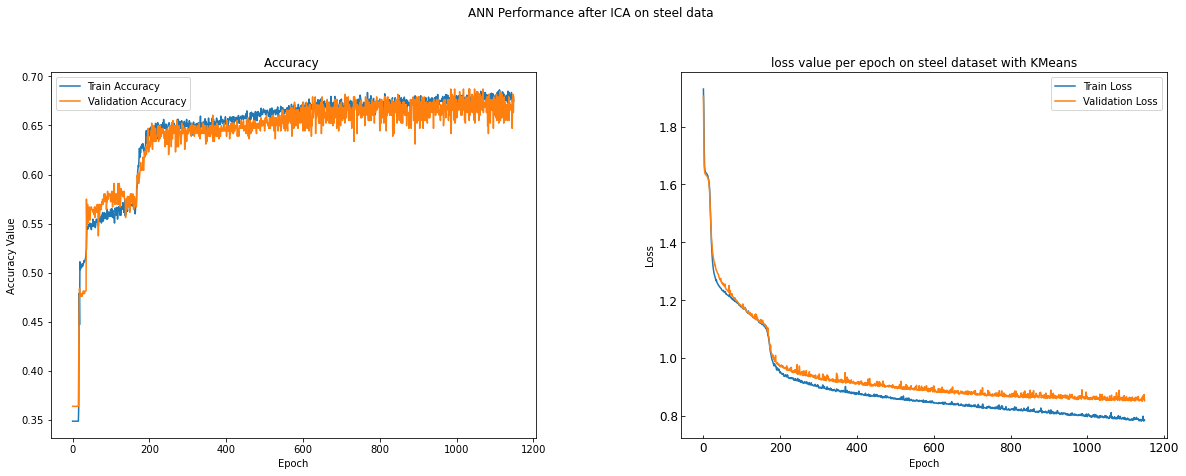

In [98]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance after ICA on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history_KMeans.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history_KMeans.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy ')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history_KMeans.history['loss'], label='Train Loss')
ax2.plot(range(1150), history_KMeans.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('loss value per epoch on steel dataset with KMeans')
l2 = ax2.legend(loc="best")

## GMM + NN

In [99]:
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(X_train_scaled)
X_train_gmm = gmm.predict_proba(X_train_scaled)
X_test_gmm = gmm.predict_proba(X_test_scaled)

In [100]:
# Initialize the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

#Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#Fitting the ANN to the Training set
history_GMM = classifier.fit(X_train_gmm, y_train_encoded, validation_data=(X_test_gmm, y_test_encoded),batch_size = 100, epochs = 1150)

Epoch 1/1150
15/15 [==============================] - 0s 12ms/step - loss: 1.9409 - accuracy: 0.3264 - val_loss: 1.9352 - val_accuracy: 0.3636
Epoch 2/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9297 - accuracy: 0.3485 - val_loss: 1.9230 - val_accuracy: 0.3636
Epoch 3/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.9161 - accuracy: 0.3485 - val_loss: 1.9083 - val_accuracy: 0.3636
Epoch 4/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8992 - accuracy: 0.3485 - val_loss: 1.8887 - val_accuracy: 0.3636
Epoch 5/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8768 - accuracy: 0.3485 - val_loss: 1.8629 - val_accuracy: 0.3636
Epoch 6/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8475 - accuracy: 0.3485 - val_loss: 1.8303 - val_accuracy: 0.3636
Epoch 7/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.8114 - accuracy: 0.3485 - val_loss: 1.7927 - val_accuracy: 0.3636
Epoch

15/15 [==============================] - 0s 2ms/step - loss: 1.2833 - accuracy: 0.5164 - val_loss: 1.3110 - val_accuracy: 0.5000
Epoch 116/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2828 - accuracy: 0.5164 - val_loss: 1.3108 - val_accuracy: 0.5000
Epoch 117/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2824 - accuracy: 0.5164 - val_loss: 1.3106 - val_accuracy: 0.5000
Epoch 118/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2821 - accuracy: 0.5164 - val_loss: 1.3104 - val_accuracy: 0.5000
Epoch 119/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2817 - accuracy: 0.5164 - val_loss: 1.3101 - val_accuracy: 0.5000
Epoch 120/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2814 - accuracy: 0.5164 - val_loss: 1.3095 - val_accuracy: 0.5000
Epoch 121/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2813 - accuracy: 0.5164 - val_loss: 1.3091 - val_accuracy: 0.5000
Epoch 1

Epoch 172/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2724 - accuracy: 0.5164 - val_loss: 1.2997 - val_accuracy: 0.5000
Epoch 173/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2726 - accuracy: 0.5164 - val_loss: 1.3001 - val_accuracy: 0.5000
Epoch 174/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2723 - accuracy: 0.5164 - val_loss: 1.2998 - val_accuracy: 0.5000
Epoch 175/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2722 - accuracy: 0.5164 - val_loss: 1.2993 - val_accuracy: 0.5000
Epoch 176/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2721 - accuracy: 0.5164 - val_loss: 1.2996 - val_accuracy: 0.5000
Epoch 177/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2720 - accuracy: 0.5164 - val_loss: 1.2990 - val_accuracy: 0.5000
Epoch 178/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2720 - accuracy: 0.5164 - val_loss: 1.2991 - val_accuracy:

Epoch 229/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2687 - accuracy: 0.5164 - val_loss: 1.2959 - val_accuracy: 0.5000
Epoch 230/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2694 - accuracy: 0.5164 - val_loss: 1.2951 - val_accuracy: 0.5000
Epoch 231/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2685 - accuracy: 0.5164 - val_loss: 1.2954 - val_accuracy: 0.5000
Epoch 232/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2686 - accuracy: 0.5164 - val_loss: 1.2957 - val_accuracy: 0.5000
Epoch 233/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2690 - accuracy: 0.5164 - val_loss: 1.2954 - val_accuracy: 0.5000
Epoch 234/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2686 - accuracy: 0.5164 - val_loss: 1.2954 - val_accuracy: 0.5000
Epoch 235/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2684 - accuracy: 0.5164 - val_loss: 1.2956 - val_accuracy:

Epoch 342/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2499 - accuracy: 0.5164 - val_loss: 1.2705 - val_accuracy: 0.5000
Epoch 343/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2490 - accuracy: 0.5164 - val_loss: 1.2697 - val_accuracy: 0.5000
Epoch 344/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2482 - accuracy: 0.5164 - val_loss: 1.2684 - val_accuracy: 0.5000
Epoch 345/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2475 - accuracy: 0.5164 - val_loss: 1.2672 - val_accuracy: 0.5000
Epoch 346/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2468 - accuracy: 0.5164 - val_loss: 1.2652 - val_accuracy: 0.5000
Epoch 347/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2459 - accuracy: 0.5164 - val_loss: 1.2643 - val_accuracy: 0.5000
Epoch 348/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2453 - accuracy: 0.5164 - val_loss: 1.2630 - val_accuracy:

Epoch 399/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2231 - accuracy: 0.5405 - val_loss: 1.2179 - val_accuracy: 0.5829
Epoch 400/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2228 - accuracy: 0.5405 - val_loss: 1.2177 - val_accuracy: 0.5829
Epoch 401/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2228 - accuracy: 0.5405 - val_loss: 1.2172 - val_accuracy: 0.5829
Epoch 402/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2226 - accuracy: 0.5405 - val_loss: 1.2166 - val_accuracy: 0.5829
Epoch 403/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2225 - accuracy: 0.5405 - val_loss: 1.2167 - val_accuracy: 0.5829
Epoch 404/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2221 - accuracy: 0.5405 - val_loss: 1.2166 - val_accuracy: 0.5829
Epoch 405/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2219 - accuracy: 0.5405 - val_loss: 1.2159 - val_accuracy:

Epoch 456/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2155 - accuracy: 0.5405 - val_loss: 1.2069 - val_accuracy: 0.5829
Epoch 457/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2156 - accuracy: 0.5405 - val_loss: 1.2070 - val_accuracy: 0.5829
Epoch 458/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2153 - accuracy: 0.5405 - val_loss: 1.2071 - val_accuracy: 0.5829
Epoch 459/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2151 - accuracy: 0.5405 - val_loss: 1.2069 - val_accuracy: 0.5829
Epoch 460/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2151 - accuracy: 0.5405 - val_loss: 1.2063 - val_accuracy: 0.5829
Epoch 461/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2150 - accuracy: 0.5405 - val_loss: 1.2060 - val_accuracy: 0.5829
Epoch 462/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2147 - accuracy: 0.5405 - val_loss: 1.2065 - val_accuracy:

Epoch 513/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2095 - accuracy: 0.5405 - val_loss: 1.2005 - val_accuracy: 0.5829
Epoch 514/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2096 - accuracy: 0.5405 - val_loss: 1.2005 - val_accuracy: 0.5829
Epoch 515/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2095 - accuracy: 0.5405 - val_loss: 1.2003 - val_accuracy: 0.5829
Epoch 516/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2095 - accuracy: 0.5405 - val_loss: 1.2004 - val_accuracy: 0.5829
Epoch 517/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2098 - accuracy: 0.5405 - val_loss: 1.1999 - val_accuracy: 0.5829
Epoch 518/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.2095 - accuracy: 0.5405 - val_loss: 1.2006 - val_accuracy: 0.5829
Epoch 519/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.2097 - accuracy: 0.5405 - val_loss: 1.2004 - val_accuracy:

Epoch 626/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1893 - accuracy: 0.5405 - val_loss: 1.1884 - val_accuracy: 0.5829
Epoch 627/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1891 - accuracy: 0.5405 - val_loss: 1.1887 - val_accuracy: 0.5829
Epoch 628/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1890 - accuracy: 0.5405 - val_loss: 1.1887 - val_accuracy: 0.5829
Epoch 629/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1888 - accuracy: 0.5405 - val_loss: 1.1888 - val_accuracy: 0.5829
Epoch 630/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1884 - accuracy: 0.5405 - val_loss: 1.1888 - val_accuracy: 0.5829
Epoch 631/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1890 - accuracy: 0.5405 - val_loss: 1.1885 - val_accuracy: 0.5829
Epoch 632/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1885 - accuracy: 0.5405 - val_loss: 1.1884 - val_accuracy:

Epoch 683/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1834 - accuracy: 0.5405 - val_loss: 1.1873 - val_accuracy: 0.5829
Epoch 684/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1833 - accuracy: 0.5405 - val_loss: 1.1880 - val_accuracy: 0.5829
Epoch 685/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1830 - accuracy: 0.5405 - val_loss: 1.1875 - val_accuracy: 0.5829
Epoch 686/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1832 - accuracy: 0.5405 - val_loss: 1.1870 - val_accuracy: 0.5829
Epoch 687/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1833 - accuracy: 0.5405 - val_loss: 1.1872 - val_accuracy: 0.5829
Epoch 688/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1831 - accuracy: 0.5405 - val_loss: 1.1881 - val_accuracy: 0.5829
Epoch 689/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1830 - accuracy: 0.5405 - val_loss: 1.1880 - val_accuracy:

Epoch 740/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1810 - accuracy: 0.5405 - val_loss: 1.1878 - val_accuracy: 0.5829
Epoch 741/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1802 - accuracy: 0.5405 - val_loss: 1.1863 - val_accuracy: 0.5829
Epoch 742/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1803 - accuracy: 0.5405 - val_loss: 1.1870 - val_accuracy: 0.5829
Epoch 743/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1800 - accuracy: 0.5405 - val_loss: 1.1861 - val_accuracy: 0.5829
Epoch 744/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1801 - accuracy: 0.5405 - val_loss: 1.1862 - val_accuracy: 0.5829
Epoch 745/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1803 - accuracy: 0.5405 - val_loss: 1.1863 - val_accuracy: 0.5829
Epoch 746/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1798 - accuracy: 0.5405 - val_loss: 1.1868 - val_accuracy:

Epoch 797/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1783 - accuracy: 0.5405 - val_loss: 1.1858 - val_accuracy: 0.5829
Epoch 798/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1785 - accuracy: 0.5405 - val_loss: 1.1855 - val_accuracy: 0.5829
Epoch 799/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1783 - accuracy: 0.5405 - val_loss: 1.1859 - val_accuracy: 0.5829
Epoch 800/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1791 - accuracy: 0.5405 - val_loss: 1.1866 - val_accuracy: 0.5829
Epoch 801/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1781 - accuracy: 0.5405 - val_loss: 1.1864 - val_accuracy: 0.5829
Epoch 802/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1782 - accuracy: 0.5405 - val_loss: 1.1859 - val_accuracy: 0.5829
Epoch 803/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1781 - accuracy: 0.5405 - val_loss: 1.1863 - val_accuracy:

Epoch 854/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1772 - accuracy: 0.5405 - val_loss: 1.1859 - val_accuracy: 0.5829
Epoch 855/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1769 - accuracy: 0.5405 - val_loss: 1.1847 - val_accuracy: 0.5829
Epoch 856/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1768 - accuracy: 0.5405 - val_loss: 1.1845 - val_accuracy: 0.5829
Epoch 857/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1767 - accuracy: 0.5405 - val_loss: 1.1848 - val_accuracy: 0.5829
Epoch 858/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1769 - accuracy: 0.5405 - val_loss: 1.1842 - val_accuracy: 0.5829
Epoch 859/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1770 - accuracy: 0.5405 - val_loss: 1.1847 - val_accuracy: 0.5829
Epoch 860/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1767 - accuracy: 0.5405 - val_loss: 1.1845 - val_accuracy:

Epoch 911/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1760 - accuracy: 0.5405 - val_loss: 1.1843 - val_accuracy: 0.5829
Epoch 912/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1757 - accuracy: 0.5405 - val_loss: 1.1832 - val_accuracy: 0.5829
Epoch 913/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1762 - accuracy: 0.5405 - val_loss: 1.1841 - val_accuracy: 0.5829
Epoch 914/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1753 - accuracy: 0.5405 - val_loss: 1.1839 - val_accuracy: 0.5829
Epoch 915/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1756 - accuracy: 0.5405 - val_loss: 1.1836 - val_accuracy: 0.5829
Epoch 916/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1754 - accuracy: 0.5405 - val_loss: 1.1833 - val_accuracy: 0.5829
Epoch 917/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1754 - accuracy: 0.5405 - val_loss: 1.1831 - val_accuracy:

Epoch 968/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1749 - accuracy: 0.5405 - val_loss: 1.1829 - val_accuracy: 0.5829
Epoch 969/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1747 - accuracy: 0.5405 - val_loss: 1.1823 - val_accuracy: 0.5829
Epoch 970/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1745 - accuracy: 0.5405 - val_loss: 1.1830 - val_accuracy: 0.5829
Epoch 971/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1758 - accuracy: 0.5405 - val_loss: 1.1834 - val_accuracy: 0.5829
Epoch 972/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1747 - accuracy: 0.5405 - val_loss: 1.1825 - val_accuracy: 0.5829
Epoch 973/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1747 - accuracy: 0.5405 - val_loss: 1.1825 - val_accuracy: 0.5829
Epoch 974/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1745 - accuracy: 0.5405 - val_loss: 1.1825 - val_accuracy:

15/15 [==============================] - 0s 1ms/step - loss: 1.1733 - accuracy: 0.5405 - val_loss: 1.1818 - val_accuracy: 0.5829
Epoch 1081/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1733 - accuracy: 0.5405 - val_loss: 1.1813 - val_accuracy: 0.5829
Epoch 1082/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1732 - accuracy: 0.5405 - val_loss: 1.1811 - val_accuracy: 0.5829
Epoch 1083/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1734 - accuracy: 0.5405 - val_loss: 1.1812 - val_accuracy: 0.5829
Epoch 1084/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1732 - accuracy: 0.5405 - val_loss: 1.1810 - val_accuracy: 0.5829
Epoch 1085/1150
15/15 [==============================] - 0s 1ms/step - loss: 1.1734 - accuracy: 0.5405 - val_loss: 1.1818 - val_accuracy: 0.5829
Epoch 1086/1150
15/15 [==============================] - 0s 2ms/step - loss: 1.1730 - accuracy: 0.5405 - val_loss: 1.1811 - val_accuracy: 0.5829
E

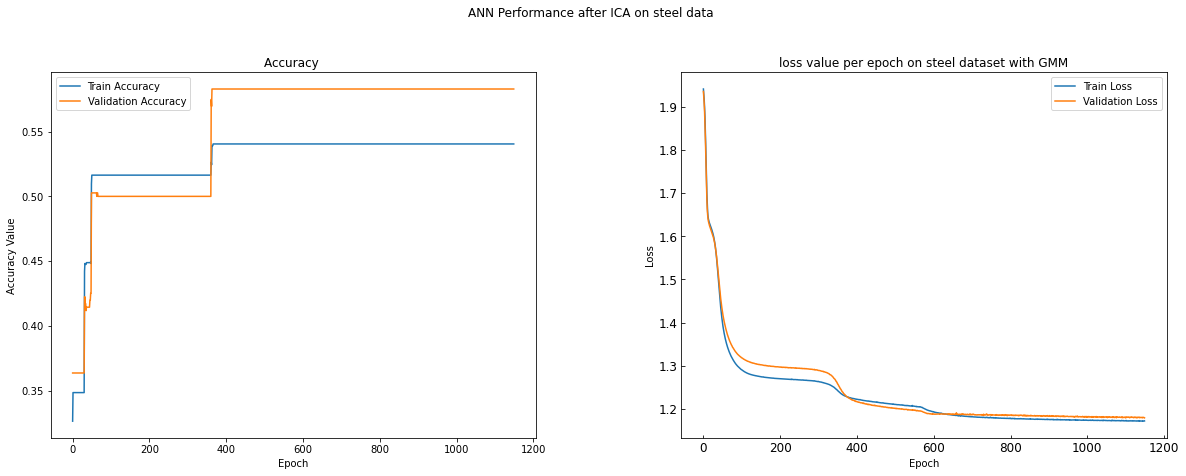

In [101]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('ANN Performance after ICA on steel data', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#epochs = list(range(1,1151))
ax1.plot(range(1150), history_GMM.history['accuracy'], label='Train Accuracy')
ax1.plot(range(1150), history_GMM.history['val_accuracy'], label='Validation Accuracy')
plt.tick_params(direction="in", labelsize=12)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy ')
l1 = ax1.legend(loc="best")

ax2.plot(range(1150), history_GMM.history['loss'], label='Train Loss')
ax2.plot(range(1150), history_GMM.history['val_loss'], label='Validation Loss')
plt.tick_params(direction="in", labelsize=12)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('loss value per epoch on steel dataset with GMM')
l2 = ax2.legend(loc="best")